![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "SP-Brazil"
infer_parameters_from_data = True
results_suffix = ".sp-brazil"
run_sensitivity_analysis = False


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
0,2019-12-31,Afghanistan,0,0,0,0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
51552,2020-02-27,SP-Brazil,0,0,1,0,45919049.0
51553,2020-02-26,São Paulo-SP-Brazil,0,0,1,0,12252023.0
51554,2020-02-26,SP-Brazil,0,0,1,0,45919049.0
51555,2020-02-25,São Paulo-SP-Brazil,1,0,1,0,12252023.0
51556,2020-02-25,SP-Brazil,1,0,1,0,45919049.0


In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
941,2020-05-04,Lucas do Rio Verde-MT-Brazil,0,0,7,1,65534.0
942,2020-05-04,Mirassol d'Oeste-MT-Brazil,0,0,8,1,27739.0
943,2020-05-04,Nova Monte Verde-MT-Brazil,0,0,1,0,9178.0
925,2020-05-04,Alta Floresta-MT-Brazil,0,0,2,0,51782.0
292,2020-05-04,Acaraú-CE-Brazil,0,0,31,1,62641.0


Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,2540,128,28698,2375,45919049.0,NaN,430470,NaN
2020-05-01,1676,136,30374,2511,45919049.0,NaN,455610,NaN
2020-05-02,800,75,31174,2586,45919049.0,NaN,467610,NaN
2020-05-03,598,41,31772,2627,45919049.0,NaN,476580,NaN
2020-05-04,0,0,31772,2627,45919049.0,NaN,476580,NaN


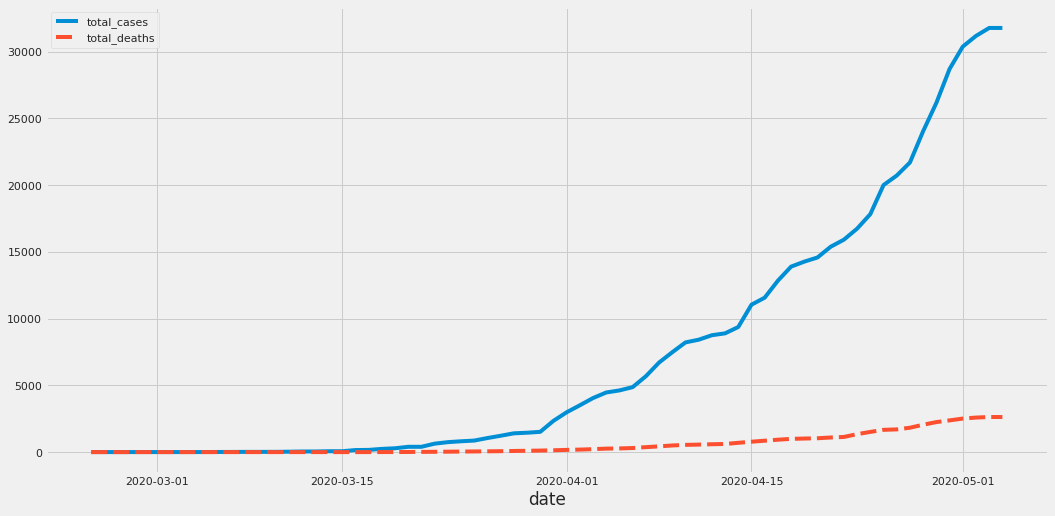

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

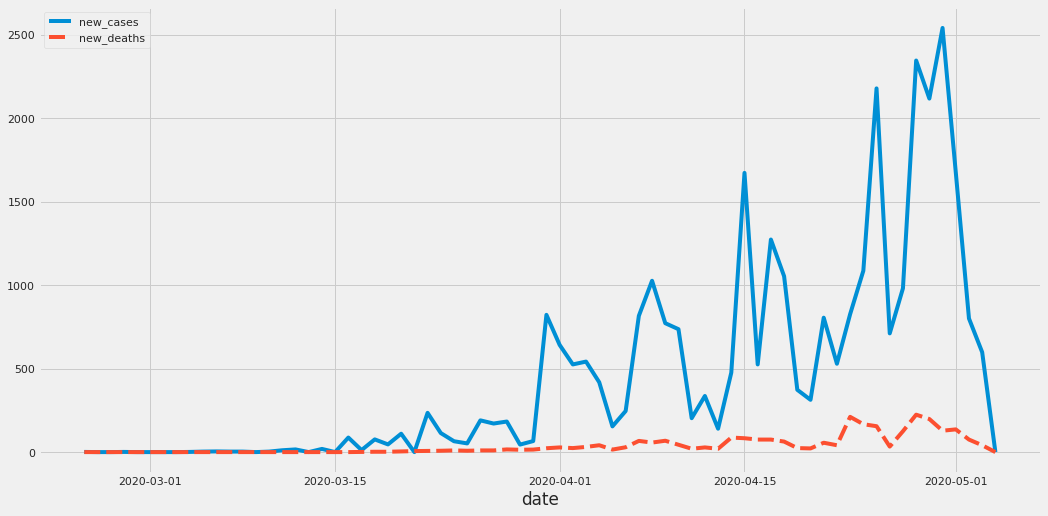

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-03-14 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-03-14 00:00:00, population_size=45919049.0, initially_infected=975.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-14,4.591807e+07,975.000000,0.000000,0.000000,0.000000,0.000000,0.000000,975.000000,975.000000
2020-03-15,4.591807e+07,97.500000,0.000000,877.500000,877.500000,0.000000,0.000000,975.000000,975.000000
2020-03-16,4.591737e+07,711.735094,701.985094,702.000000,87.750000,263.250000,263.250000,1413.735094,1676.985094
2020-03-17,4.591681e+07,632.753000,561.579490,1131.961585,640.561585,473.850000,210.600000,1764.714585,2238.564585
2020-03-18,4.591590e+07,968.800421,905.525121,1361.850809,569.477700,813.438475,339.588475,2330.651230,3144.089706


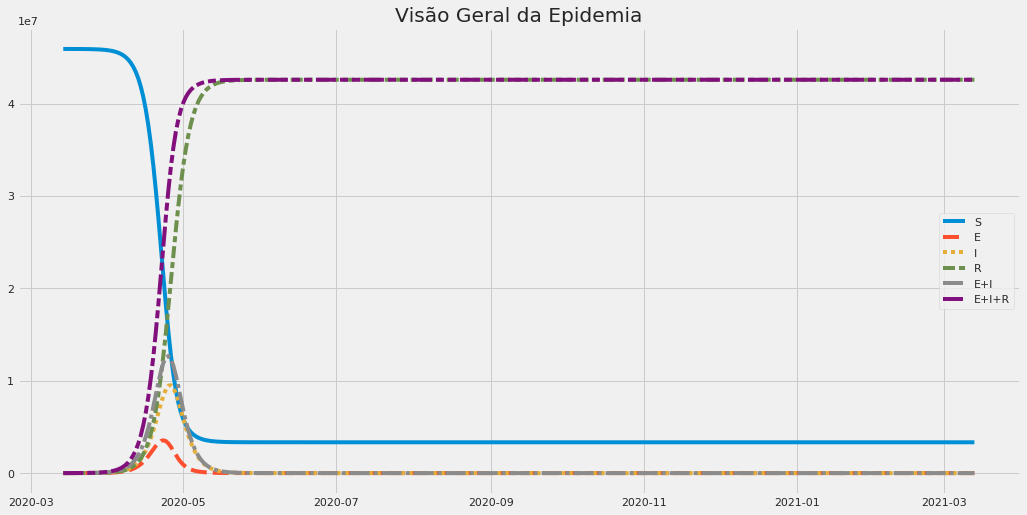

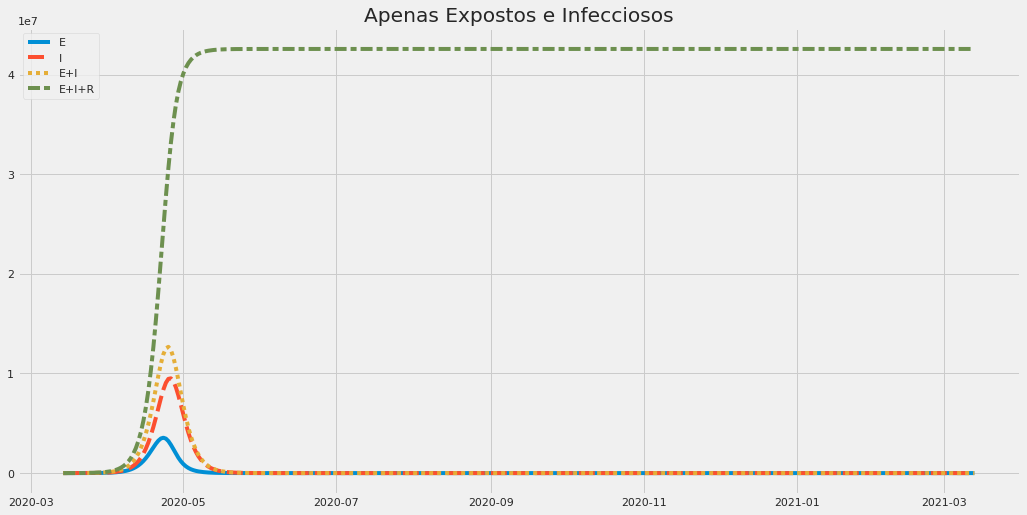

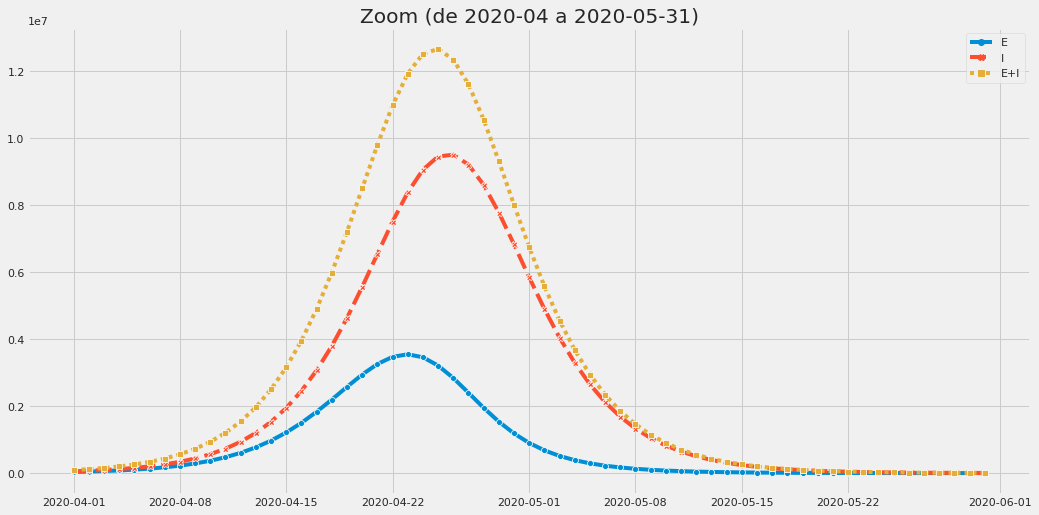

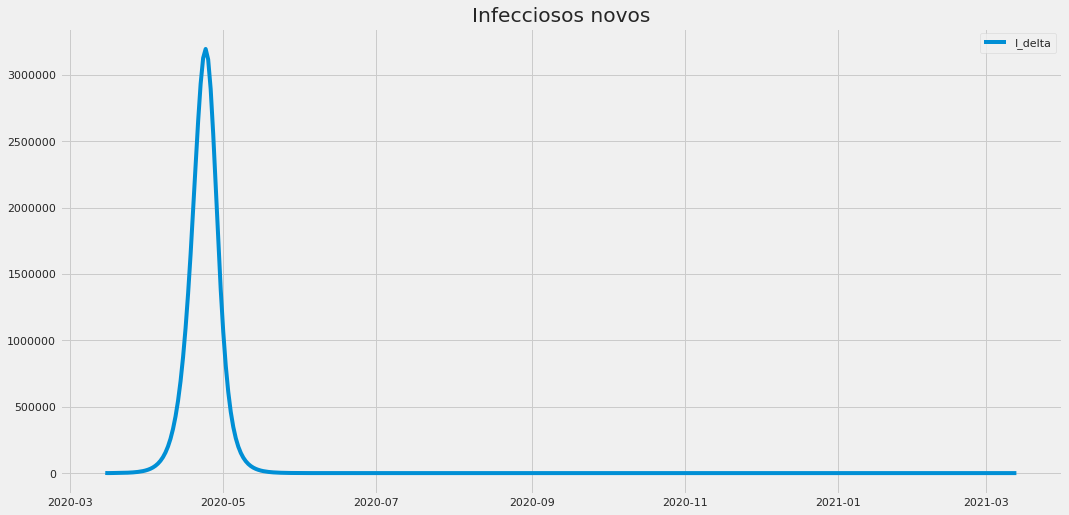

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

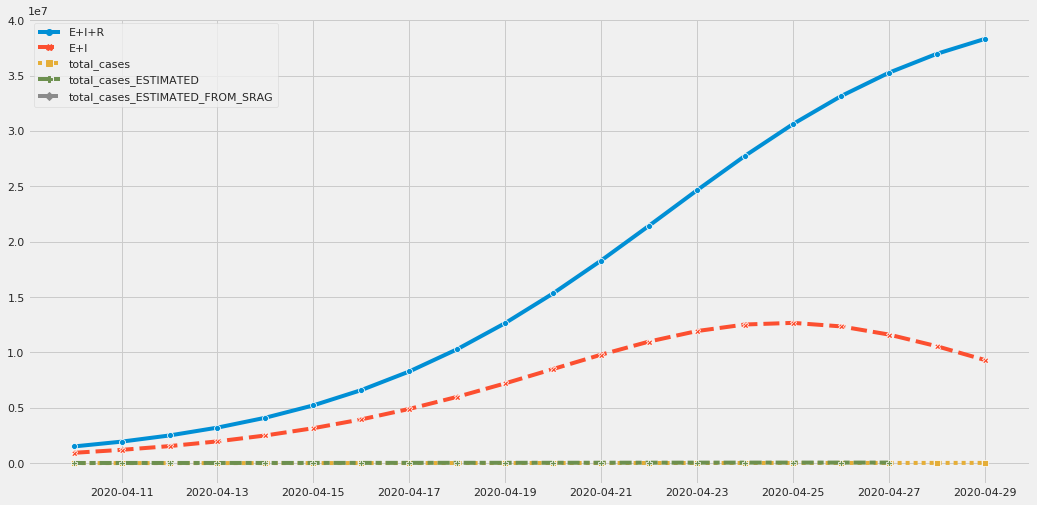

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-14,4.591807e+07,975.000000,0.000000,0.000000,0.000000,0.000000,0.000000,975.000000,975.000000
2020-03-15,4.591807e+07,0.000000,0.000000,975.000000,975.000000,0.000000,0.000000,975.000000,975.000000
2020-03-16,4.591720e+07,877.481368,877.481368,585.000000,0.000000,390.000000,390.000000,1462.481368,1852.481368
2020-03-17,4.591667e+07,526.478760,526.478760,1228.481368,877.481368,624.000000,234.000000,1754.960128,2378.960128
2020-03-18,4.591556e+07,1105.575951,1105.575951,1263.567581,526.478760,1115.392547,491.392547,2369.143531,3484.536079


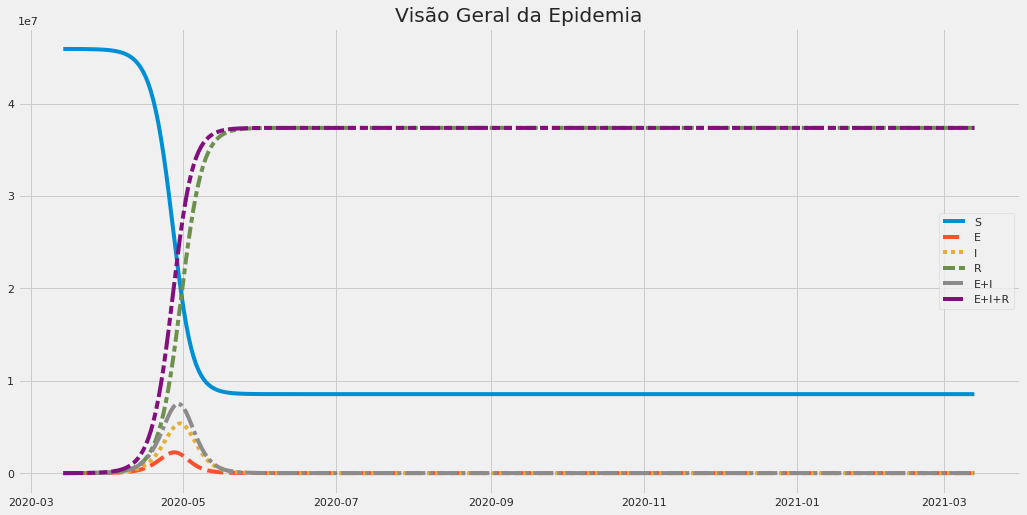

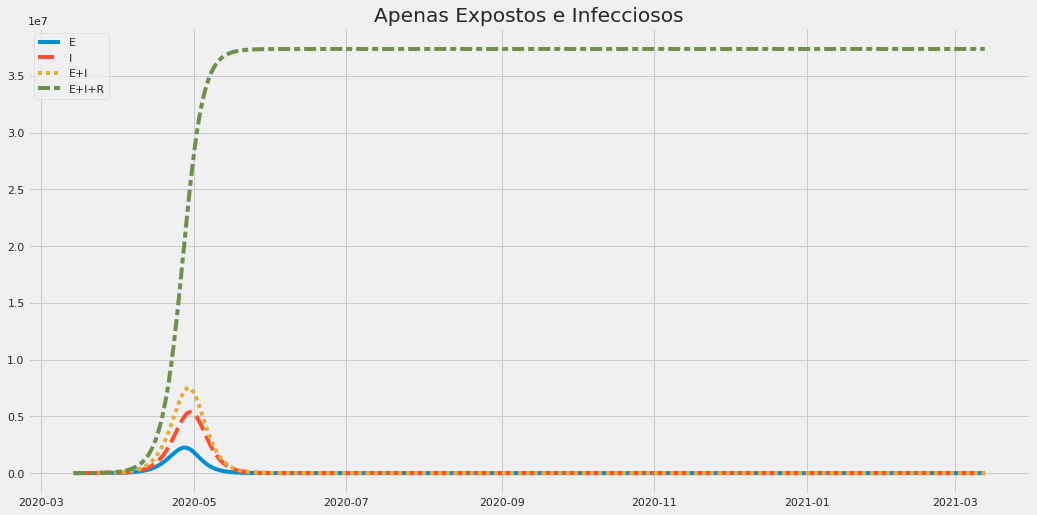

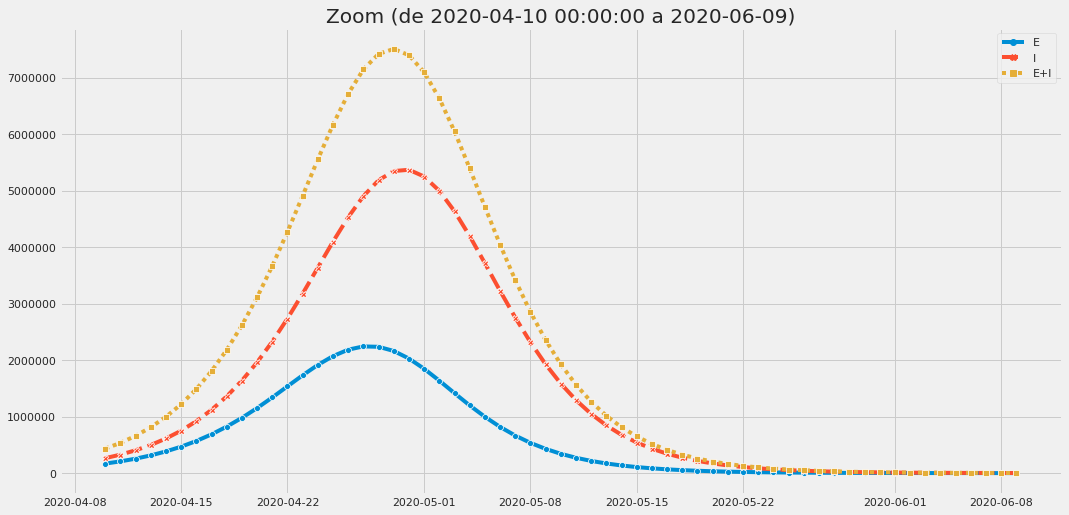

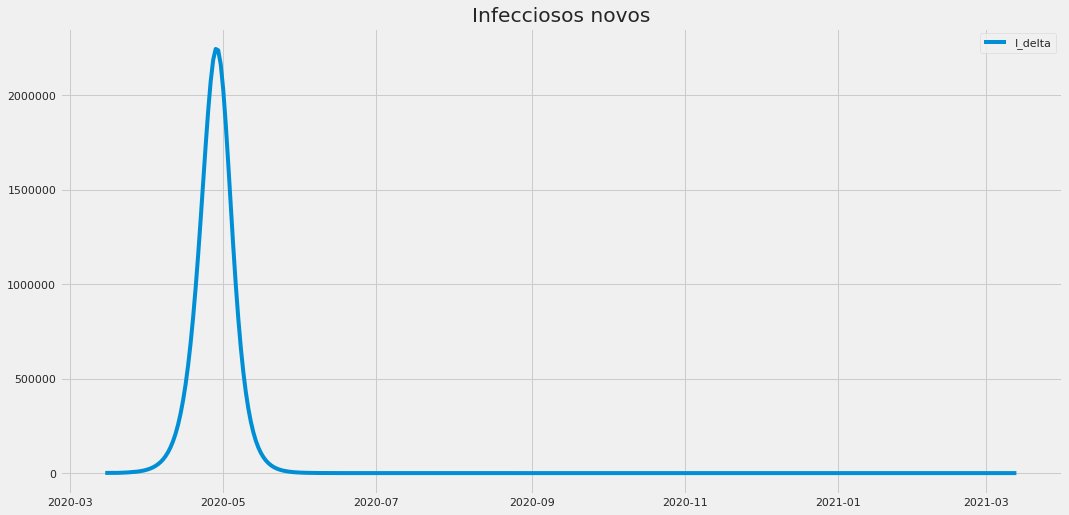

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

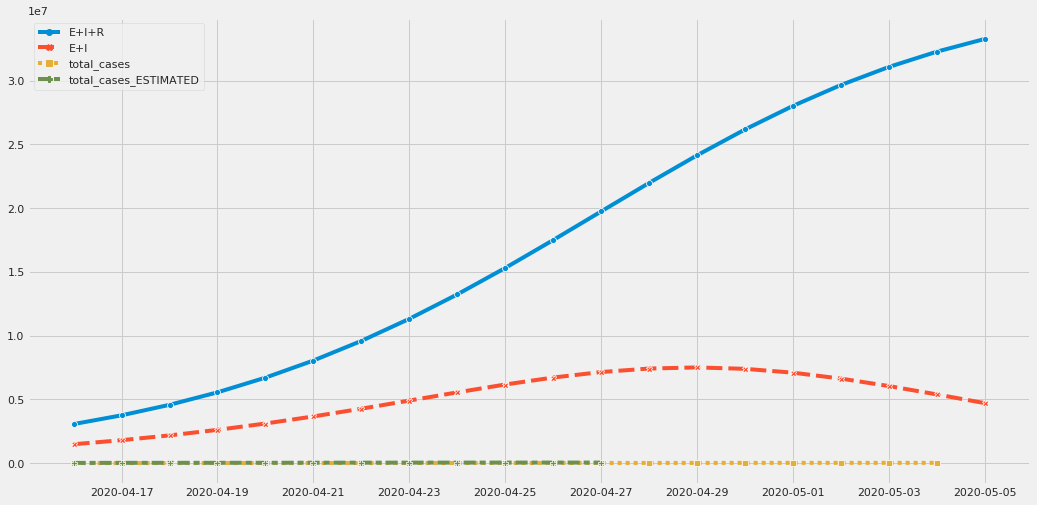

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|▏         | 13/1000 [00:00<00:08, 121.90trial/s, best loss: 2495.647363682073]

  2%|▎         | 25/1000 [00:00<00:08, 117.71trial/s, best loss: 1037.1334803166606]

  4%|▎         | 35/1000 [00:00<00:08, 108.41trial/s, best loss: 816.2390306277249] 

  4%|▍         | 44/1000 [00:00<00:09, 99.76trial/s, best loss: 768.5782354990183] 

  5%|▌         | 53/1000 [00:00<00:09, 96.18trial/s, best loss: 768.5782354990183]

  6%|▌         | 61/1000 [00:00<00:10, 90.13trial/s, best loss: 768.5782354990183]

  7%|▋         | 69/1000 [00:00<00:11, 79.49trial/s, best loss: 768.5782354990183]

  8%|▊         | 78/1000 [00:00<00:11, 81.21trial/s, best loss: 768.5782354990183]

  9%|▊         | 87/1000 [00:00<00:11, 82.09trial/s, best loss: 768.5782354990183]

 10%|▉         | 96/1000 [00:01<00:11, 81.96trial/s, best loss: 768.5782354990183]

 10%|█         | 105/1000 [00:01<00:10, 82.55trial/s, best loss: 768.5782354990183]

 11%|█▏        | 114/1000 [00:01<00:10, 83.14trial/s, best loss: 768.5782354990183]

 12%|█▏        | 123/1000 [00:01<00:11, 79.40trial/s, best loss: 768.5782354990183]

 13%|█▎        | 131/1000 [00:01<00:11, 78.59trial/s, best loss: 768.5782354990183]

 14%|█▍        | 139/1000 [00:01<00:11, 73.89trial/s, best loss: 768.5782354990183]

 15%|█▍        | 147/1000 [00:01<00:11, 73.72trial/s, best loss: 768.5782354990183]

 16%|█▌        | 155/1000 [00:01<00:11, 74.25trial/s, best loss: 768.5782354990183]

 16%|█▋        | 163/1000 [00:01<00:11, 74.62trial/s, best loss: 768.5782354990183]

 17%|█▋        | 171/1000 [00:02<00:11, 74.47trial/s, best loss: 768.5782354990183]

 18%|█▊        | 179/1000 [00:02<00:12, 68.39trial/s, best loss: 768.5782354990183]

 19%|█▊        | 186/1000 [00:02<00:12, 63.81trial/s, best loss: 768.5782354990183]

 19%|█▉        | 194/1000 [00:02<00:12, 66.20trial/s, best loss: 768.5782354990183]

 20%|██        | 202/1000 [00:02<00:11, 66.84trial/s, best loss: 768.5782354990183]

 21%|██        | 210/1000 [00:02<00:11, 68.83trial/s, best loss: 768.5782354990183]

 22%|██▏       | 218/1000 [00:02<00:11, 70.40trial/s, best loss: 768.5782354990183]

 23%|██▎       | 226/1000 [00:02<00:10, 70.54trial/s, best loss: 768.5782354990183]

 23%|██▎       | 234/1000 [00:03<00:11, 69.13trial/s, best loss: 611.6202514698418]

 24%|██▍       | 241/1000 [00:03<00:11, 68.28trial/s, best loss: 611.6202514698418]

 25%|██▍       | 249/1000 [00:03<00:10, 69.86trial/s, best loss: 611.6202514698418]

 26%|██▌       | 257/1000 [00:03<00:10, 70.15trial/s, best loss: 611.6202514698418]

 26%|██▋       | 265/1000 [00:03<00:10, 70.81trial/s, best loss: 611.6202514698418]

 27%|██▋       | 273/1000 [00:03<00:10, 71.17trial/s, best loss: 611.6202514698418]

 28%|██▊       | 281/1000 [00:03<00:09, 71.97trial/s, best loss: 611.6202514698418]

 29%|██▉       | 289/1000 [00:03<00:09, 72.10trial/s, best loss: 611.6202514698418]

 30%|██▉       | 297/1000 [00:03<00:09, 73.01trial/s, best loss: 611.6202514698418]

 30%|███       | 305/1000 [00:04<00:11, 61.23trial/s, best loss: 611.6202514698418]

 31%|███▏      | 313/1000 [00:04<00:10, 64.41trial/s, best loss: 611.6202514698418]

 32%|███▏      | 321/1000 [00:04<00:10, 67.15trial/s, best loss: 611.6202514698418]

 33%|███▎      | 328/1000 [00:04<00:10, 66.72trial/s, best loss: 611.6202514698418]

 34%|███▎      | 335/1000 [00:04<00:10, 65.07trial/s, best loss: 611.6202514698418]

 34%|███▍      | 342/1000 [00:04<00:10, 62.25trial/s, best loss: 611.6202514698418]

 35%|███▍      | 349/1000 [00:04<00:10, 63.44trial/s, best loss: 611.6202514698418]

 36%|███▌      | 356/1000 [00:04<00:10, 62.96trial/s, best loss: 611.6202514698418]

 36%|███▋      | 363/1000 [00:04<00:09, 63.77trial/s, best loss: 611.6202514698418]

 37%|███▋      | 370/1000 [00:05<00:09, 64.16trial/s, best loss: 600.3524747054005]

 38%|███▊      | 377/1000 [00:05<00:09, 64.74trial/s, best loss: 600.3524747054005]

 38%|███▊      | 384/1000 [00:05<00:09, 65.11trial/s, best loss: 600.3524747054005]

 39%|███▉      | 391/1000 [00:05<00:10, 55.59trial/s, best loss: 600.3524747054005]

 40%|███▉      | 398/1000 [00:05<00:10, 56.31trial/s, best loss: 594.2866377638978]

 40%|████      | 405/1000 [00:05<00:10, 58.69trial/s, best loss: 594.2866377638978]

 41%|████      | 412/1000 [00:05<00:09, 60.07trial/s, best loss: 594.2866377638978]

 42%|████▏     | 419/1000 [00:05<00:09, 61.43trial/s, best loss: 594.2866377638978]

 43%|████▎     | 426/1000 [00:06<00:09, 62.37trial/s, best loss: 594.2866377638978]

 43%|████▎     | 433/1000 [00:06<00:09, 62.88trial/s, best loss: 594.2866377638978]

 44%|████▍     | 440/1000 [00:06<00:08, 63.15trial/s, best loss: 594.2866377638978]

 45%|████▍     | 447/1000 [00:06<00:08, 63.27trial/s, best loss: 594.2866377638978]

 45%|████▌     | 454/1000 [00:06<00:08, 62.73trial/s, best loss: 594.2866377638978]

 46%|████▌     | 461/1000 [00:06<00:08, 62.02trial/s, best loss: 594.2866377638978]

 47%|████▋     | 468/1000 [00:06<00:08, 62.48trial/s, best loss: 594.2866377638978]

 48%|████▊     | 475/1000 [00:06<00:08, 63.06trial/s, best loss: 594.2866377638978]

 48%|████▊     | 482/1000 [00:06<00:08, 62.92trial/s, best loss: 594.2866377638978]

 49%|████▉     | 489/1000 [00:07<00:08, 61.75trial/s, best loss: 594.2866377638978]

 50%|████▉     | 496/1000 [00:07<00:08, 60.30trial/s, best loss: 594.2866377638978]

 50%|█████     | 503/1000 [00:07<00:08, 60.82trial/s, best loss: 594.2866377638978]

 51%|█████     | 510/1000 [00:07<00:08, 60.29trial/s, best loss: 594.2866377638978]

 52%|█████▏    | 517/1000 [00:07<00:08, 59.99trial/s, best loss: 594.2866377638978]

 52%|█████▏    | 524/1000 [00:07<00:08, 57.93trial/s, best loss: 594.2866377638978]

 53%|█████▎    | 531/1000 [00:07<00:07, 58.93trial/s, best loss: 594.2866377638978]

 54%|█████▍    | 538/1000 [00:07<00:07, 59.48trial/s, best loss: 594.2866377638978]

 54%|█████▍    | 544/1000 [00:07<00:07, 59.27trial/s, best loss: 594.2866377638978]

 55%|█████▌    | 550/1000 [00:08<00:07, 58.23trial/s, best loss: 594.2866377638978]

 56%|█████▌    | 556/1000 [00:08<00:07, 57.99trial/s, best loss: 594.2866377638978]

 56%|█████▌    | 562/1000 [00:08<00:07, 58.27trial/s, best loss: 594.2866377638978]

 57%|█████▋    | 568/1000 [00:08<00:07, 57.44trial/s, best loss: 594.2866377638978]

 57%|█████▋    | 574/1000 [00:08<00:07, 56.07trial/s, best loss: 594.2866377638978]

 58%|█████▊    | 580/1000 [00:08<00:07, 54.93trial/s, best loss: 594.2866377638978]

 59%|█████▊    | 586/1000 [00:08<00:07, 55.74trial/s, best loss: 594.2866377638978]

 59%|█████▉    | 592/1000 [00:08<00:07, 56.44trial/s, best loss: 594.2866377638978]

 60%|█████▉    | 598/1000 [00:08<00:07, 56.37trial/s, best loss: 594.2866377638978]

 60%|██████    | 604/1000 [00:09<00:07, 56.30trial/s, best loss: 569.443098179636] 

 61%|██████    | 610/1000 [00:09<00:06, 55.74trial/s, best loss: 569.443098179636]

 62%|██████▏   | 616/1000 [00:09<00:06, 56.07trial/s, best loss: 569.443098179636]

 62%|██████▏   | 622/1000 [00:09<00:06, 56.62trial/s, best loss: 569.443098179636]

 63%|██████▎   | 628/1000 [00:09<00:06, 56.52trial/s, best loss: 569.443098179636]

 63%|██████▎   | 634/1000 [00:09<00:06, 56.86trial/s, best loss: 569.443098179636]

 64%|██████▍   | 640/1000 [00:09<00:06, 55.22trial/s, best loss: 569.443098179636]

 65%|██████▍   | 646/1000 [00:09<00:06, 55.49trial/s, best loss: 569.443098179636]

 65%|██████▌   | 652/1000 [00:09<00:06, 55.60trial/s, best loss: 569.443098179636]

 66%|██████▌   | 658/1000 [00:09<00:06, 55.81trial/s, best loss: 569.443098179636]

 66%|██████▋   | 664/1000 [00:10<00:06, 55.91trial/s, best loss: 569.443098179636]

 67%|██████▋   | 670/1000 [00:10<00:05, 55.78trial/s, best loss: 569.443098179636]

 68%|██████▊   | 676/1000 [00:10<00:05, 55.88trial/s, best loss: 569.443098179636]

 68%|██████▊   | 682/1000 [00:10<00:06, 50.93trial/s, best loss: 569.443098179636]

 69%|██████▉   | 688/1000 [00:10<00:06, 50.11trial/s, best loss: 557.2291820078095]

 69%|██████▉   | 694/1000 [00:10<00:06, 50.98trial/s, best loss: 557.2291820078095]

 70%|███████   | 700/1000 [00:10<00:05, 51.85trial/s, best loss: 555.7312957651191]

 71%|███████   | 706/1000 [00:10<00:05, 52.60trial/s, best loss: 555.7312957651191]

 71%|███████   | 712/1000 [00:11<00:05, 53.10trial/s, best loss: 555.7312957651191]

 72%|███████▏  | 718/1000 [00:11<00:05, 52.96trial/s, best loss: 555.7312957651191]

 72%|███████▏  | 724/1000 [00:11<00:05, 47.76trial/s, best loss: 555.7312957651191]

 73%|███████▎  | 730/1000 [00:11<00:05, 49.07trial/s, best loss: 555.7312957651191]

 74%|███████▎  | 736/1000 [00:11<00:05, 50.47trial/s, best loss: 555.7312957651191]

 74%|███████▍  | 742/1000 [00:11<00:05, 50.09trial/s, best loss: 555.7312957651191]

 75%|███████▍  | 748/1000 [00:11<00:04, 50.81trial/s, best loss: 555.5795518309775]

 75%|███████▌  | 754/1000 [00:11<00:04, 51.77trial/s, best loss: 555.5795518309775]

 76%|███████▌  | 760/1000 [00:11<00:04, 52.10trial/s, best loss: 555.5795518309775]

 77%|███████▋  | 766/1000 [00:12<00:04, 52.48trial/s, best loss: 555.5795518309775]

 77%|███████▋  | 772/1000 [00:12<00:04, 48.91trial/s, best loss: 555.5795518309775]

 78%|███████▊  | 778/1000 [00:12<00:04, 50.00trial/s, best loss: 555.5795518309775]

 78%|███████▊  | 784/1000 [00:12<00:04, 49.17trial/s, best loss: 555.5795518309775]

 79%|███████▉  | 789/1000 [00:12<00:04, 48.45trial/s, best loss: 555.5795518309775]

 80%|███████▉  | 795/1000 [00:12<00:04, 49.86trial/s, best loss: 555.5795518309775]

 80%|████████  | 801/1000 [00:12<00:04, 47.94trial/s, best loss: 555.5795518309775]

 81%|████████  | 806/1000 [00:12<00:04, 48.38trial/s, best loss: 555.5795518309775]

 81%|████████  | 812/1000 [00:13<00:03, 49.48trial/s, best loss: 555.5795518309775]

 82%|████████▏ | 818/1000 [00:13<00:03, 50.05trial/s, best loss: 555.5795518309775]

 82%|████████▏ | 824/1000 [00:13<00:03, 50.81trial/s, best loss: 555.5795518309775]

 83%|████████▎ | 830/1000 [00:13<00:03, 48.91trial/s, best loss: 555.5795518309775]

 84%|████████▎ | 835/1000 [00:13<00:03, 48.74trial/s, best loss: 555.5795518309775]

 84%|████████▍ | 840/1000 [00:13<00:03, 47.71trial/s, best loss: 555.5795518309775]

 84%|████████▍ | 845/1000 [00:13<00:03, 48.15trial/s, best loss: 555.5795518309775]

 85%|████████▌ | 850/1000 [00:13<00:03, 47.96trial/s, best loss: 555.5795518309775]

 86%|████████▌ | 856/1000 [00:13<00:02, 48.69trial/s, best loss: 555.5795518309775]

 86%|████████▌ | 861/1000 [00:14<00:03, 43.27trial/s, best loss: 555.5795518309775]

 87%|████████▋ | 866/1000 [00:14<00:02, 45.08trial/s, best loss: 555.5795518309775]

 87%|████████▋ | 872/1000 [00:14<00:02, 46.83trial/s, best loss: 555.5795518309775]

 88%|████████▊ | 877/1000 [00:14<00:02, 47.64trial/s, best loss: 555.5795518309775]

 88%|████████▊ | 882/1000 [00:14<00:02, 47.58trial/s, best loss: 555.5795518309775]

 89%|████████▊ | 887/1000 [00:14<00:02, 46.85trial/s, best loss: 555.5795518309775]

 89%|████████▉ | 893/1000 [00:14<00:02, 47.69trial/s, best loss: 555.5795518309775]

 90%|████████▉ | 899/1000 [00:14<00:02, 48.44trial/s, best loss: 555.5795518309775]

 90%|█████████ | 904/1000 [00:14<00:01, 48.50trial/s, best loss: 555.5795518309775]

 91%|█████████ | 910/1000 [00:15<00:01, 49.29trial/s, best loss: 555.5795518309775]

 92%|█████████▏| 916/1000 [00:15<00:01, 49.80trial/s, best loss: 555.5795518309775]

 92%|█████████▏| 922/1000 [00:15<00:01, 50.10trial/s, best loss: 555.5795518309775]

 93%|█████████▎| 928/1000 [00:15<00:01, 49.86trial/s, best loss: 555.5795518309775]

 93%|█████████▎| 934/1000 [00:15<00:01, 49.25trial/s, best loss: 555.5795518309775]

 94%|█████████▍| 939/1000 [00:15<00:01, 49.12trial/s, best loss: 555.5795518309775]

 94%|█████████▍| 944/1000 [00:15<00:01, 48.91trial/s, best loss: 555.5795518309775]

 95%|█████████▍| 949/1000 [00:15<00:01, 48.82trial/s, best loss: 555.5795518309775]

 95%|█████████▌| 954/1000 [00:15<00:00, 49.03trial/s, best loss: 555.5795518309775]

 96%|█████████▌| 959/1000 [00:16<00:00, 49.01trial/s, best loss: 555.5795518309775]

 96%|█████████▋| 964/1000 [00:16<00:00, 49.01trial/s, best loss: 555.5795518309775]

 97%|█████████▋| 970/1000 [00:16<00:00, 49.29trial/s, best loss: 555.5795518309775]

 98%|█████████▊| 975/1000 [00:16<00:00, 48.86trial/s, best loss: 555.5795518309775]

 98%|█████████▊| 980/1000 [00:16<00:00, 48.67trial/s, best loss: 555.5795518309775]

 98%|█████████▊| 985/1000 [00:16<00:00, 47.68trial/s, best loss: 555.5795518309775]

 99%|█████████▉| 990/1000 [00:16<00:00, 48.27trial/s, best loss: 555.5795518309775]

100%|█████████▉| 995/1000 [00:16<00:00, 48.28trial/s, best loss: 555.5795518309775]

100%|██████████| 1000/1000 [00:16<00:00, 48.36trial/s, best loss: 555.5795518309775]

100%|██████████| 1000/1000 [00:16<00:00, 59.10trial/s, best loss: 555.5795518309775]


Best parameters found: {'alpha': 0.9965720141738998, 'beta': 0.9975833924342613, 'gamma': 0.701488897157074}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-16,4.591710e+07,969.300474,969.289017,293.381445,3.330829,681.607098,681.607098,1262.681919,1944.289017
2020-03-17,4.591681e+07,295.982813,292.660065,1053.555345,965.977726,887.410924,205.803826,1349.538158,2236.949082
2020-03-18,4.591576e+07,1051.972740,1050.958115,609.466156,294.968188,1626.468301,739.057377,1661.438896,3287.907196
2020-03-19,4.591515e+07,611.555929,607.949782,1230.299006,1048.366592,2054.002042,427.533741,1841.854936,3895.856978
2020-03-20,4.591393e+07,1229.318133,1227.221728,976.717437,609.459524,2917.043136,863.041093,2206.035570,5123.078706


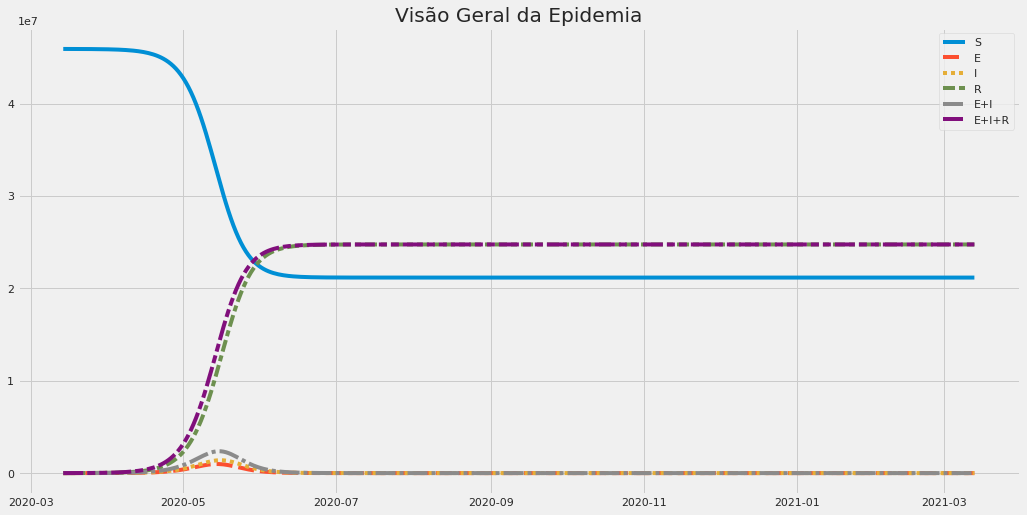

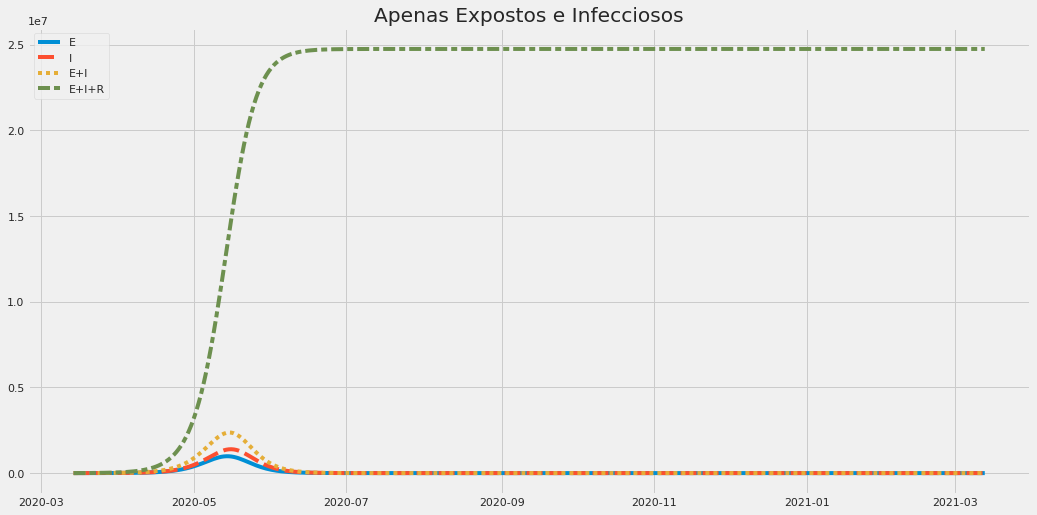

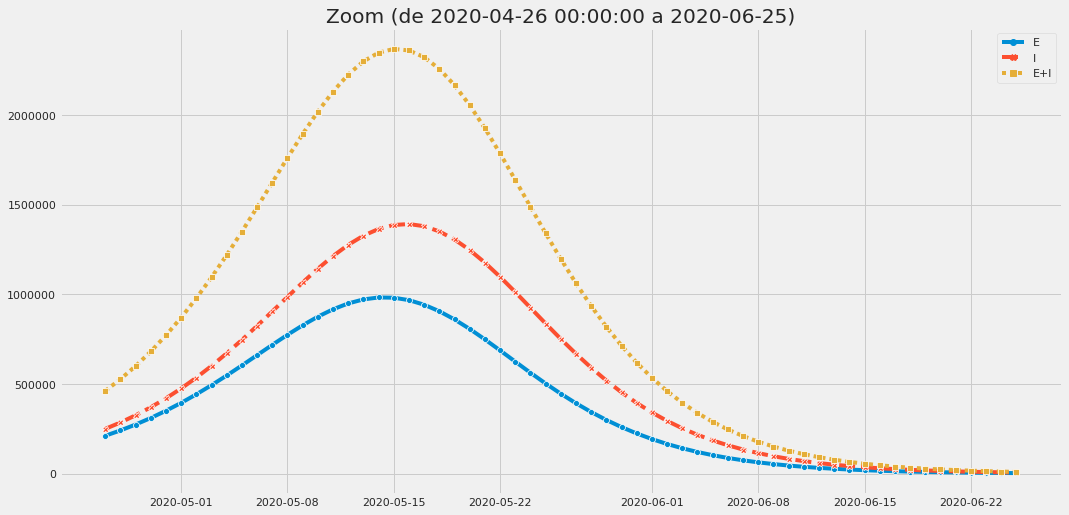

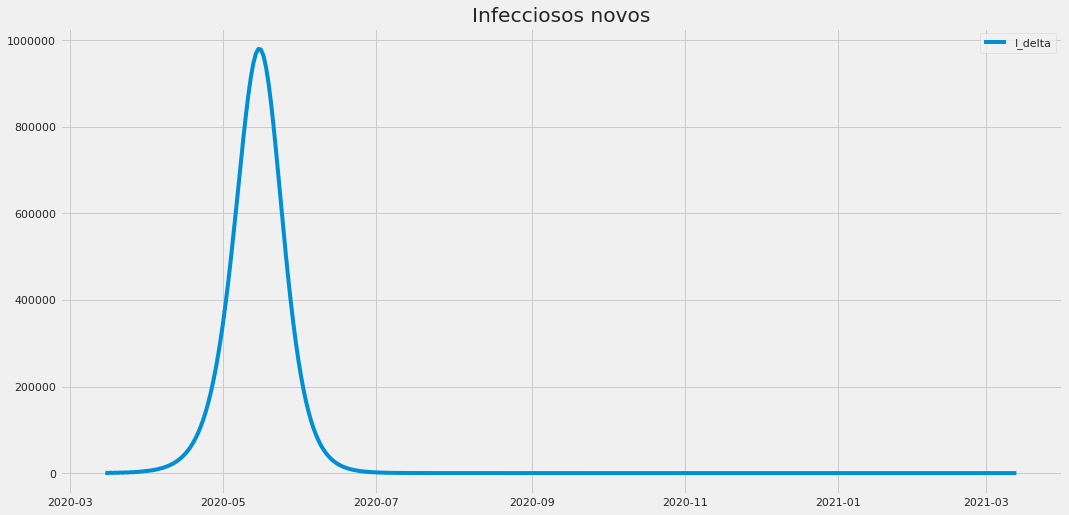

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,2540,128,28698,2375,45919049.0,NaN,430470,NaN
2020-05-01,1676,136,30374,2511,45919049.0,NaN,455610,NaN
2020-05-02,800,75,31174,2586,45919049.0,NaN,467610,NaN
2020-05-03,598,41,31772,2627,45919049.0,NaN,476580,NaN
2020-05-04,0,0,31772,2627,45919049.0,NaN,476580,NaN


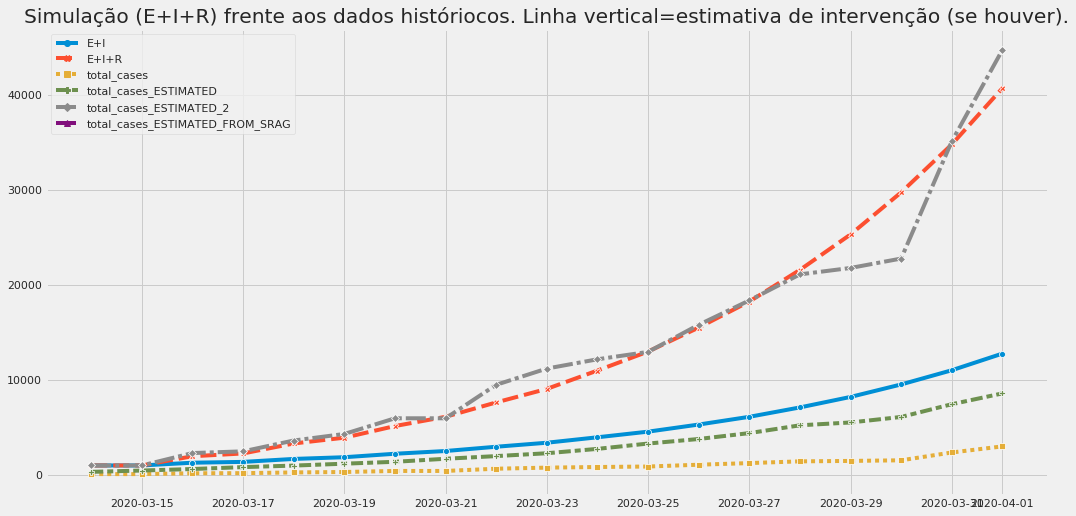

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 8/3000 [00:00<00:38, 77.83trial/s, best loss: 95336.73297844183]

  0%|          | 14/3000 [00:00<00:41, 71.16trial/s, best loss: 95336.73297844183]

  1%|          | 19/3000 [00:00<00:47, 62.67trial/s, best loss: 66554.88699811796]

  1%|          | 23/3000 [00:00<00:56, 52.78trial/s, best loss: 66554.88699811796]

  1%|          | 28/3000 [00:00<01:01, 48.49trial/s, best loss: 66554.88699811796]

  1%|          | 33/3000 [00:00<01:03, 46.55trial/s, best loss: 66554.88699811796]

  1%|▏         | 38/3000 [00:00<01:05, 45.32trial/s, best loss: 66554.88699811796]

  1%|▏         | 43/3000 [00:00<01:22, 35.64trial/s, best loss: 66554.88699811796]

  2%|▏         | 47/3000 [00:01<01:24, 34.77trial/s, best loss: 66554.88699811796]

  2%|▏         | 51/3000 [00:01<01:27, 33.70trial/s, best loss: 66554.88699811796]

  2%|▏         | 55/3000 [00:01<01:25, 34.40trial/s, best loss: 64274.63949156406]

  2%|▏         | 59/3000 [00:01<01:22, 35.74trial/s, best loss: 35436.231107453124]

  2%|▏         | 63/3000 [00:01<01:22, 35.63trial/s, best loss: 35436.231107453124]

  2%|▏         | 68/3000 [00:01<01:18, 37.27trial/s, best loss: 35436.231107453124]

  2%|▏         | 73/3000 [00:01<01:16, 38.31trial/s, best loss: 21100.60227064641] 

  3%|▎         | 77/3000 [00:01<01:16, 38.06trial/s, best loss: 17941.49535962978]

  3%|▎         | 82/3000 [00:02<01:13, 39.49trial/s, best loss: 17941.49535962978]

  3%|▎         | 86/3000 [00:02<01:13, 39.41trial/s, best loss: 17941.49535962978]

  3%|▎         | 91/3000 [00:02<01:12, 40.12trial/s, best loss: 17941.49535962978]

  3%|▎         | 96/3000 [00:02<01:12, 39.95trial/s, best loss: 17941.49535962978]

  3%|▎         | 101/3000 [00:02<01:17, 37.42trial/s, best loss: 17941.49535962978]

  4%|▎         | 105/3000 [00:02<01:21, 35.64trial/s, best loss: 17941.49535962978]

  4%|▎         | 110/3000 [00:02<01:16, 37.55trial/s, best loss: 17941.49535962978]

  4%|▍         | 114/3000 [00:02<01:32, 31.10trial/s, best loss: 17941.49535962978]

  4%|▍         | 118/3000 [00:03<01:35, 30.28trial/s, best loss: 12340.317527700112]

  4%|▍         | 122/3000 [00:03<01:29, 32.10trial/s, best loss: 12340.317527700112]

  4%|▍         | 126/3000 [00:03<01:25, 33.70trial/s, best loss: 12340.317527700112]

  4%|▍         | 131/3000 [00:03<01:19, 36.00trial/s, best loss: 12340.317527700112]

  5%|▍         | 136/3000 [00:03<01:15, 37.71trial/s, best loss: 12340.317527700112]

  5%|▍         | 141/3000 [00:03<01:14, 38.46trial/s, best loss: 12340.317527700112]

  5%|▍         | 145/3000 [00:03<01:15, 37.59trial/s, best loss: 12340.317527700112]

  5%|▍         | 149/3000 [00:03<01:20, 35.39trial/s, best loss: 12340.317527700112]

  5%|▌         | 153/3000 [00:03<01:18, 36.29trial/s, best loss: 12340.317527700112]

  5%|▌         | 157/3000 [00:04<01:17, 36.85trial/s, best loss: 12340.317527700112]

  5%|▌         | 161/3000 [00:04<01:16, 37.07trial/s, best loss: 12340.317527700112]

  6%|▌         | 165/3000 [00:04<01:19, 35.66trial/s, best loss: 12340.317527700112]

  6%|▌         | 170/3000 [00:04<01:15, 37.63trial/s, best loss: 12340.317527700112]

  6%|▌         | 175/3000 [00:04<01:12, 39.17trial/s, best loss: 12340.317527700112]

  6%|▌         | 180/3000 [00:04<01:10, 40.13trial/s, best loss: 12340.317527700112]

  6%|▌         | 185/3000 [00:04<01:08, 41.05trial/s, best loss: 12340.317527700112]

  6%|▋         | 190/3000 [00:04<01:08, 41.15trial/s, best loss: 12340.317527700112]

  6%|▋         | 195/3000 [00:05<01:07, 41.28trial/s, best loss: 12340.317527700112]

  7%|▋         | 200/3000 [00:05<01:08, 41.11trial/s, best loss: 12340.317527700112]

  7%|▋         | 205/3000 [00:05<01:08, 40.61trial/s, best loss: 12340.317527700112]

  7%|▋         | 210/3000 [00:05<01:15, 37.10trial/s, best loss: 12340.317527700112]

  7%|▋         | 215/3000 [00:05<01:13, 38.13trial/s, best loss: 12340.317527700112]

  7%|▋         | 219/3000 [00:05<01:12, 38.53trial/s, best loss: 12340.317527700112]

  7%|▋         | 224/3000 [00:05<01:10, 39.29trial/s, best loss: 12340.317527700112]

  8%|▊         | 229/3000 [00:05<01:10, 39.51trial/s, best loss: 12340.317527700112]

  8%|▊         | 234/3000 [00:06<01:09, 39.83trial/s, best loss: 12340.317527700112]

  8%|▊         | 238/3000 [00:06<01:11, 38.38trial/s, best loss: 12340.317527700112]

  8%|▊         | 243/3000 [00:06<01:11, 38.81trial/s, best loss: 12340.317527700112]

  8%|▊         | 247/3000 [00:06<01:10, 39.01trial/s, best loss: 12340.317527700112]

  8%|▊         | 251/3000 [00:06<01:10, 39.21trial/s, best loss: 12340.317527700112]

  8%|▊         | 255/3000 [00:06<01:09, 39.36trial/s, best loss: 12340.317527700112]

  9%|▊         | 259/3000 [00:06<01:09, 39.24trial/s, best loss: 12340.317527700112]

  9%|▉         | 263/3000 [00:06<01:09, 39.33trial/s, best loss: 12340.317527700112]

  9%|▉         | 267/3000 [00:06<01:09, 39.32trial/s, best loss: 12340.317527700112]

  9%|▉         | 271/3000 [00:06<01:10, 38.71trial/s, best loss: 12340.317527700112]

  9%|▉         | 275/3000 [00:07<01:11, 38.12trial/s, best loss: 12340.317527700112]

  9%|▉         | 279/3000 [00:07<01:10, 38.43trial/s, best loss: 12340.317527700112]

  9%|▉         | 283/3000 [00:07<01:10, 38.57trial/s, best loss: 12340.317527700112]

 10%|▉         | 287/3000 [00:07<01:10, 38.75trial/s, best loss: 12340.317527700112]

 10%|▉         | 291/3000 [00:07<01:09, 38.77trial/s, best loss: 12340.317527700112]

 10%|▉         | 295/3000 [00:07<01:09, 38.76trial/s, best loss: 12340.317527700112]

 10%|▉         | 299/3000 [00:07<01:10, 38.57trial/s, best loss: 12340.317527700112]

 10%|█         | 303/3000 [00:07<01:10, 38.48trial/s, best loss: 12340.317527700112]

 10%|█         | 307/3000 [00:07<01:11, 37.54trial/s, best loss: 12340.317527700112]

 10%|█         | 311/3000 [00:08<01:12, 37.10trial/s, best loss: 12340.317527700112]

 10%|█         | 315/3000 [00:08<01:14, 35.96trial/s, best loss: 12340.317527700112]

 11%|█         | 319/3000 [00:08<01:13, 36.38trial/s, best loss: 12340.317527700112]

 11%|█         | 323/3000 [00:08<01:13, 36.53trial/s, best loss: 12340.317527700112]

 11%|█         | 327/3000 [00:08<01:12, 36.71trial/s, best loss: 12340.317527700112]

 11%|█         | 331/3000 [00:08<01:12, 36.78trial/s, best loss: 12340.317527700112]

 11%|█         | 335/3000 [00:08<01:12, 36.82trial/s, best loss: 12340.317527700112]

 11%|█▏        | 339/3000 [00:08<01:12, 36.81trial/s, best loss: 12340.317527700112]

 11%|█▏        | 343/3000 [00:08<01:13, 36.08trial/s, best loss: 12340.317527700112]

 12%|█▏        | 347/3000 [00:09<01:14, 35.62trial/s, best loss: 12340.317527700112]

 12%|█▏        | 351/3000 [00:09<01:17, 34.12trial/s, best loss: 12340.317527700112]

 12%|█▏        | 355/3000 [00:09<01:18, 33.75trial/s, best loss: 12340.317527700112]

 12%|█▏        | 359/3000 [00:09<01:19, 33.27trial/s, best loss: 12340.317527700112]

 12%|█▏        | 363/3000 [00:09<01:19, 33.02trial/s, best loss: 12340.317527700112]

 12%|█▏        | 367/3000 [00:09<01:20, 32.66trial/s, best loss: 12340.317527700112]

 12%|█▏        | 371/3000 [00:09<01:20, 32.54trial/s, best loss: 12340.317527700112]

 12%|█▎        | 375/3000 [00:09<01:30, 28.98trial/s, best loss: 12340.317527700112]

 13%|█▎        | 378/3000 [00:10<01:38, 26.62trial/s, best loss: 12340.317527700112]

 13%|█▎        | 381/3000 [00:10<01:44, 25.12trial/s, best loss: 12340.317527700112]

 13%|█▎        | 385/3000 [00:10<01:37, 26.81trial/s, best loss: 12340.317527700112]

 13%|█▎        | 389/3000 [00:10<01:32, 28.14trial/s, best loss: 12340.317527700112]

 13%|█▎        | 393/3000 [00:10<01:29, 28.98trial/s, best loss: 12340.317527700112]

 13%|█▎        | 397/3000 [00:10<01:27, 29.60trial/s, best loss: 12340.317527700112]

 13%|█▎        | 401/3000 [00:10<01:26, 30.04trial/s, best loss: 12340.317527700112]

 14%|█▎        | 405/3000 [00:11<01:26, 30.06trial/s, best loss: 12340.317527700112]

 14%|█▎        | 409/3000 [00:11<01:29, 29.06trial/s, best loss: 12340.317527700112]

 14%|█▎        | 412/3000 [00:11<01:28, 29.18trial/s, best loss: 12340.317527700112]

 14%|█▍        | 415/3000 [00:11<01:29, 28.93trial/s, best loss: 12340.317527700112]

 14%|█▍        | 418/3000 [00:11<01:28, 29.13trial/s, best loss: 12340.317527700112]

 14%|█▍        | 422/3000 [00:11<01:27, 29.48trial/s, best loss: 12340.317527700112]

 14%|█▍        | 425/3000 [00:11<01:27, 29.59trial/s, best loss: 12340.317527700112]

 14%|█▍        | 428/3000 [00:11<01:28, 29.14trial/s, best loss: 12340.317527700112]

 14%|█▍        | 432/3000 [00:11<01:27, 29.31trial/s, best loss: 12340.317527700112]

 15%|█▍        | 436/3000 [00:12<01:26, 29.59trial/s, best loss: 12340.317527700112]

 15%|█▍        | 439/3000 [00:12<01:29, 28.64trial/s, best loss: 12340.317527700112]

 15%|█▍        | 442/3000 [00:12<01:40, 25.55trial/s, best loss: 12340.317527700112]

 15%|█▍        | 445/3000 [00:12<01:35, 26.62trial/s, best loss: 12340.317527700112]

 15%|█▍        | 448/3000 [00:12<01:33, 27.40trial/s, best loss: 12340.317527700112]

 15%|█▌        | 451/3000 [00:12<01:31, 27.99trial/s, best loss: 12340.317527700112]

 15%|█▌        | 454/3000 [00:12<01:29, 28.46trial/s, best loss: 12340.317527700112]

 15%|█▌        | 457/3000 [00:12<01:28, 28.76trial/s, best loss: 12340.317527700112]

 15%|█▌        | 460/3000 [00:12<01:28, 28.73trial/s, best loss: 12340.317527700112]

 15%|█▌        | 463/3000 [00:13<01:28, 28.57trial/s, best loss: 12340.317527700112]

 16%|█▌        | 466/3000 [00:13<01:33, 27.19trial/s, best loss: 12340.317527700112]

 16%|█▌        | 469/3000 [00:13<01:31, 27.65trial/s, best loss: 12340.317527700112]

 16%|█▌        | 472/3000 [00:13<01:30, 28.00trial/s, best loss: 12340.317527700112]

 16%|█▌        | 475/3000 [00:13<01:29, 28.21trial/s, best loss: 12340.317527700112]

 16%|█▌        | 478/3000 [00:13<01:28, 28.46trial/s, best loss: 12340.317527700112]

 16%|█▌        | 481/3000 [00:13<01:28, 28.58trial/s, best loss: 12340.317527700112]

 16%|█▌        | 484/3000 [00:13<01:27, 28.73trial/s, best loss: 12340.317527700112]

 16%|█▌        | 487/3000 [00:13<01:27, 28.77trial/s, best loss: 12340.317527700112]

 16%|█▋        | 490/3000 [00:14<01:29, 28.14trial/s, best loss: 12340.317527700112]

 16%|█▋        | 493/3000 [00:14<01:32, 27.20trial/s, best loss: 12340.317527700112]

 17%|█▋        | 496/3000 [00:14<01:30, 27.60trial/s, best loss: 12340.317527700112]

 17%|█▋        | 499/3000 [00:14<01:31, 27.48trial/s, best loss: 12340.317527700112]

 17%|█▋        | 502/3000 [00:14<01:30, 27.62trial/s, best loss: 12340.317527700112]

 17%|█▋        | 505/3000 [00:14<01:30, 27.72trial/s, best loss: 12340.317527700112]

 17%|█▋        | 508/3000 [00:14<01:29, 27.70trial/s, best loss: 12340.317527700112]

 17%|█▋        | 511/3000 [00:14<01:29, 27.78trial/s, best loss: 12340.317527700112]

 17%|█▋        | 514/3000 [00:14<01:29, 27.85trial/s, best loss: 12340.317527700112]

 17%|█▋        | 517/3000 [00:14<01:30, 27.49trial/s, best loss: 12340.317527700112]

 17%|█▋        | 520/3000 [00:15<01:31, 26.99trial/s, best loss: 11889.320776767008]

 17%|█▋        | 523/3000 [00:15<01:31, 27.13trial/s, best loss: 11889.320776767008]

 18%|█▊        | 526/3000 [00:15<01:30, 27.27trial/s, best loss: 11889.320776767008]

 18%|█▊        | 529/3000 [00:15<01:30, 27.40trial/s, best loss: 11889.320776767008]

 18%|█▊        | 532/3000 [00:15<01:30, 27.31trial/s, best loss: 11889.320776767008]

 18%|█▊        | 535/3000 [00:15<01:30, 27.28trial/s, best loss: 11889.320776767008]

 18%|█▊        | 538/3000 [00:15<01:30, 27.16trial/s, best loss: 11889.320776767008]

 18%|█▊        | 541/3000 [00:15<01:42, 24.00trial/s, best loss: 11889.320776767008]

 18%|█▊        | 544/3000 [00:16<01:38, 24.86trial/s, best loss: 11889.320776767008]

 18%|█▊        | 547/3000 [00:16<01:38, 24.83trial/s, best loss: 11889.320776767008]

 18%|█▊        | 550/3000 [00:16<01:36, 25.49trial/s, best loss: 11889.320776767008]

 18%|█▊        | 553/3000 [00:16<01:34, 25.85trial/s, best loss: 11889.320776767008]

 19%|█▊        | 556/3000 [00:16<01:33, 26.24trial/s, best loss: 11889.320776767008]

 19%|█▊        | 559/3000 [00:16<01:33, 26.23trial/s, best loss: 11889.320776767008]

 19%|█▊        | 562/3000 [00:16<01:32, 26.47trial/s, best loss: 11889.320776767008]

 19%|█▉        | 565/3000 [00:16<01:31, 26.74trial/s, best loss: 11889.320776767008]

 19%|█▉        | 568/3000 [00:16<01:32, 26.27trial/s, best loss: 11889.320776767008]

 19%|█▉        | 571/3000 [00:17<01:31, 26.42trial/s, best loss: 11889.320776767008]

 19%|█▉        | 574/3000 [00:17<01:33, 26.09trial/s, best loss: 11889.320776767008]

 19%|█▉        | 577/3000 [00:17<01:31, 26.37trial/s, best loss: 11889.320776767008]

 19%|█▉        | 580/3000 [00:17<01:31, 26.44trial/s, best loss: 11889.320776767008]

 19%|█▉        | 583/3000 [00:17<01:31, 26.43trial/s, best loss: 11889.320776767008]

 20%|█▉        | 586/3000 [00:17<01:31, 26.52trial/s, best loss: 11889.320776767008]

 20%|█▉        | 589/3000 [00:17<01:32, 26.13trial/s, best loss: 11889.320776767008]

 20%|█▉        | 592/3000 [00:17<01:32, 26.04trial/s, best loss: 11889.320776767008]

 20%|█▉        | 595/3000 [00:17<01:32, 26.00trial/s, best loss: 10869.709249933589]

 20%|█▉        | 598/3000 [00:18<01:33, 25.68trial/s, best loss: 10869.709249933589]

 20%|██        | 601/3000 [00:18<01:32, 25.92trial/s, best loss: 10869.709249933589]

 20%|██        | 604/3000 [00:18<01:35, 25.18trial/s, best loss: 10869.709249933589]

 20%|██        | 607/3000 [00:18<01:36, 24.71trial/s, best loss: 10869.709249933589]

 20%|██        | 610/3000 [00:18<01:34, 25.19trial/s, best loss: 10869.709249933589]

 20%|██        | 613/3000 [00:18<01:35, 25.03trial/s, best loss: 10869.709249933589]

 21%|██        | 616/3000 [00:18<01:33, 25.38trial/s, best loss: 10869.709249933589]

 21%|██        | 619/3000 [00:18<01:33, 25.51trial/s, best loss: 10869.709249933589]

 21%|██        | 622/3000 [00:19<01:40, 23.69trial/s, best loss: 10869.709249933589]

 21%|██        | 625/3000 [00:19<01:38, 24.23trial/s, best loss: 10869.709249933589]

 21%|██        | 628/3000 [00:19<01:35, 24.71trial/s, best loss: 10869.709249933589]

 21%|██        | 631/3000 [00:19<01:34, 25.04trial/s, best loss: 10869.709249933589]

 21%|██        | 634/3000 [00:19<01:33, 25.29trial/s, best loss: 10869.709249933589]

 21%|██        | 637/3000 [00:19<01:33, 25.28trial/s, best loss: 10869.709249933589]

 21%|██▏       | 640/3000 [00:19<01:33, 25.38trial/s, best loss: 10869.709249933589]

 21%|██▏       | 643/3000 [00:19<01:33, 25.30trial/s, best loss: 10869.709249933589]

 22%|██▏       | 646/3000 [00:20<01:33, 25.11trial/s, best loss: 10869.709249933589]

 22%|██▏       | 649/3000 [00:20<01:36, 24.26trial/s, best loss: 10869.709249933589]

 22%|██▏       | 652/3000 [00:20<01:36, 24.35trial/s, best loss: 10869.709249933589]

 22%|██▏       | 655/3000 [00:20<01:35, 24.60trial/s, best loss: 10869.709249933589]

 22%|██▏       | 658/3000 [00:20<01:34, 24.71trial/s, best loss: 10869.709249933589]

 22%|██▏       | 661/3000 [00:20<01:34, 24.81trial/s, best loss: 10869.709249933589]

 22%|██▏       | 664/3000 [00:20<01:34, 24.66trial/s, best loss: 10869.709249933589]

 22%|██▏       | 667/3000 [00:20<01:36, 24.21trial/s, best loss: 10869.709249933589]

 22%|██▏       | 670/3000 [00:21<01:39, 23.50trial/s, best loss: 10869.709249933589]

 22%|██▏       | 673/3000 [00:21<01:43, 22.46trial/s, best loss: 10869.709249933589]

 23%|██▎       | 676/3000 [00:21<01:40, 23.09trial/s, best loss: 10869.709249933589]

 23%|██▎       | 679/3000 [00:21<01:38, 23.54trial/s, best loss: 10869.709249933589]

 23%|██▎       | 682/3000 [00:21<01:37, 23.89trial/s, best loss: 10869.709249933589]

 23%|██▎       | 685/3000 [00:21<01:36, 23.93trial/s, best loss: 10869.709249933589]

 23%|██▎       | 688/3000 [00:21<01:36, 24.00trial/s, best loss: 10869.709249933589]

 23%|██▎       | 691/3000 [00:21<01:36, 23.98trial/s, best loss: 10869.709249933589]

 23%|██▎       | 694/3000 [00:22<01:37, 23.74trial/s, best loss: 10869.709249933589]

 23%|██▎       | 697/3000 [00:22<01:40, 22.85trial/s, best loss: 10869.709249933589]

 23%|██▎       | 700/3000 [00:22<01:39, 23.19trial/s, best loss: 10869.709249933589]

 23%|██▎       | 703/3000 [00:22<01:38, 23.35trial/s, best loss: 10869.709249933589]

 24%|██▎       | 706/3000 [00:22<01:47, 21.33trial/s, best loss: 10869.709249933589]

 24%|██▎       | 709/3000 [00:22<01:43, 22.11trial/s, best loss: 10869.709249933589]

 24%|██▎       | 712/3000 [00:22<01:40, 22.66trial/s, best loss: 10869.709249933589]

 24%|██▍       | 715/3000 [00:22<01:40, 22.76trial/s, best loss: 10869.709249933589]

 24%|██▍       | 718/3000 [00:23<01:48, 21.00trial/s, best loss: 10869.709249933589]

 24%|██▍       | 721/3000 [00:23<01:50, 20.54trial/s, best loss: 10869.709249933589]

 24%|██▍       | 724/3000 [00:23<01:47, 21.27trial/s, best loss: 10869.709249933589]

 24%|██▍       | 727/3000 [00:23<01:44, 21.83trial/s, best loss: 10869.709249933589]

 24%|██▍       | 730/3000 [00:23<01:41, 22.30trial/s, best loss: 10869.709249933589]

 24%|██▍       | 733/3000 [00:23<01:40, 22.55trial/s, best loss: 10869.709249933589]

 25%|██▍       | 736/3000 [00:23<01:39, 22.73trial/s, best loss: 10869.709249933589]

 25%|██▍       | 739/3000 [00:24<01:38, 22.85trial/s, best loss: 10869.709249933589]

 25%|██▍       | 742/3000 [00:24<01:41, 22.35trial/s, best loss: 10869.709249933589]

 25%|██▍       | 745/3000 [00:24<01:40, 22.39trial/s, best loss: 10869.709249933589]

 25%|██▍       | 748/3000 [00:24<01:40, 22.50trial/s, best loss: 10869.709249933589]

 25%|██▌       | 751/3000 [00:24<01:39, 22.60trial/s, best loss: 10869.709249933589]

 25%|██▌       | 754/3000 [00:24<01:38, 22.81trial/s, best loss: 10869.709249933589]

 25%|██▌       | 757/3000 [00:24<01:38, 22.85trial/s, best loss: 10869.709249933589]

 25%|██▌       | 760/3000 [00:25<01:41, 22.12trial/s, best loss: 10869.709249933589]

 25%|██▌       | 763/3000 [00:25<01:40, 22.17trial/s, best loss: 10869.709249933589]

 26%|██▌       | 766/3000 [00:25<01:39, 22.41trial/s, best loss: 10869.709249933589]

 26%|██▌       | 769/3000 [00:25<01:39, 22.49trial/s, best loss: 10869.709249933589]

 26%|██▌       | 772/3000 [00:25<01:41, 21.99trial/s, best loss: 10869.709249933589]

 26%|██▌       | 775/3000 [00:25<01:40, 22.10trial/s, best loss: 10869.709249933589]

 26%|██▌       | 778/3000 [00:25<01:39, 22.30trial/s, best loss: 10869.709249933589]

 26%|██▌       | 781/3000 [00:25<01:39, 22.29trial/s, best loss: 10869.709249933589]

 26%|██▌       | 784/3000 [00:26<01:52, 19.67trial/s, best loss: 10869.709249933589]

 26%|██▌       | 787/3000 [00:26<01:48, 20.46trial/s, best loss: 10869.709249933589]

 26%|██▋       | 790/3000 [00:26<01:44, 21.07trial/s, best loss: 10869.709249933589]

 26%|██▋       | 793/3000 [00:26<01:42, 21.49trial/s, best loss: 10869.709249933589]

 27%|██▋       | 796/3000 [00:26<01:41, 21.71trial/s, best loss: 10869.709249933589]

 27%|██▋       | 799/3000 [00:26<01:39, 22.05trial/s, best loss: 10869.709249933589]

 27%|██▋       | 802/3000 [00:26<01:40, 21.90trial/s, best loss: 10869.709249933589]

 27%|██▋       | 805/3000 [00:27<01:47, 20.45trial/s, best loss: 10869.709249933589]

 27%|██▋       | 808/3000 [00:27<01:49, 19.97trial/s, best loss: 10869.709249933589]

 27%|██▋       | 811/3000 [00:27<01:46, 20.62trial/s, best loss: 10869.709249933589]

 27%|██▋       | 814/3000 [00:27<01:43, 21.09trial/s, best loss: 10869.709249933589]

 27%|██▋       | 817/3000 [00:27<01:42, 21.30trial/s, best loss: 10869.709249933589]

 27%|██▋       | 820/3000 [00:27<01:41, 21.58trial/s, best loss: 10869.709249933589]

 27%|██▋       | 823/3000 [00:27<01:40, 21.72trial/s, best loss: 10869.709249933589]

 28%|██▊       | 826/3000 [00:28<01:40, 21.61trial/s, best loss: 10869.709249933589]

 28%|██▊       | 829/3000 [00:28<01:39, 21.73trial/s, best loss: 10869.709249933589]

 28%|██▊       | 832/3000 [00:28<01:39, 21.89trial/s, best loss: 10869.709249933589]

 28%|██▊       | 835/3000 [00:28<01:38, 21.95trial/s, best loss: 10869.709249933589]

 28%|██▊       | 838/3000 [00:28<01:38, 21.96trial/s, best loss: 10869.709249933589]

 28%|██▊       | 841/3000 [00:28<01:37, 22.07trial/s, best loss: 10869.709249933589]

 28%|██▊       | 844/3000 [00:28<01:37, 22.05trial/s, best loss: 10869.709249933589]

 28%|██▊       | 847/3000 [00:29<01:37, 22.10trial/s, best loss: 10869.709249933589]

 28%|██▊       | 850/3000 [00:29<01:38, 21.79trial/s, best loss: 10869.709249933589]

 28%|██▊       | 853/3000 [00:29<01:38, 21.89trial/s, best loss: 10869.709249933589]

 29%|██▊       | 856/3000 [00:29<01:37, 22.02trial/s, best loss: 10869.709249933589]

 29%|██▊       | 859/3000 [00:29<01:37, 21.99trial/s, best loss: 10869.709249933589]

 29%|██▊       | 862/3000 [00:29<01:37, 21.96trial/s, best loss: 10869.709249933589]

 29%|██▉       | 865/3000 [00:29<01:47, 19.93trial/s, best loss: 10869.709249933589]

 29%|██▉       | 868/3000 [00:30<01:44, 20.38trial/s, best loss: 10869.709249933589]

 29%|██▉       | 871/3000 [00:30<01:44, 20.37trial/s, best loss: 10869.709249933589]

 29%|██▉       | 874/3000 [00:30<01:42, 20.65trial/s, best loss: 10869.709249933589]

 29%|██▉       | 877/3000 [00:30<01:40, 21.06trial/s, best loss: 10869.709249933589]

 29%|██▉       | 880/3000 [00:30<01:39, 21.29trial/s, best loss: 10869.709249933589]

 29%|██▉       | 883/3000 [00:30<01:38, 21.41trial/s, best loss: 10869.709249933589]

 30%|██▉       | 886/3000 [00:30<01:38, 21.56trial/s, best loss: 10869.709249933589]

 30%|██▉       | 889/3000 [00:31<01:38, 21.37trial/s, best loss: 10869.709249933589]

 30%|██▉       | 892/3000 [00:31<01:41, 20.80trial/s, best loss: 10869.709249933589]

 30%|██▉       | 895/3000 [00:31<01:46, 19.68trial/s, best loss: 10869.709249933589]

 30%|██▉       | 898/3000 [00:31<01:44, 20.08trial/s, best loss: 10869.709249933589]

 30%|███       | 901/3000 [00:31<01:42, 20.45trial/s, best loss: 10869.709249933589]

 30%|███       | 904/3000 [00:31<01:40, 20.77trial/s, best loss: 10869.709249933589]

 30%|███       | 907/3000 [00:31<01:40, 20.80trial/s, best loss: 10869.709249933589]

 30%|███       | 910/3000 [00:32<01:40, 20.78trial/s, best loss: 10869.709249933589]

 30%|███       | 913/3000 [00:32<01:42, 20.26trial/s, best loss: 10869.709249933589]

 31%|███       | 916/3000 [00:32<01:41, 20.48trial/s, best loss: 10869.709249933589]

 31%|███       | 919/3000 [00:32<01:41, 20.60trial/s, best loss: 10869.709249933589]

 31%|███       | 922/3000 [00:32<01:41, 20.48trial/s, best loss: 10869.709249933589]

 31%|███       | 925/3000 [00:32<01:40, 20.62trial/s, best loss: 10869.709249933589]

 31%|███       | 928/3000 [00:32<01:40, 20.67trial/s, best loss: 10869.709249933589]

 31%|███       | 931/3000 [00:33<01:42, 20.14trial/s, best loss: 10869.709249933589]

 31%|███       | 934/3000 [00:33<01:43, 20.04trial/s, best loss: 10869.709249933589]

 31%|███       | 937/3000 [00:33<01:45, 19.47trial/s, best loss: 10869.709249933589]

 31%|███▏      | 940/3000 [00:33<01:43, 19.85trial/s, best loss: 10869.709249933589]

 31%|███▏      | 942/3000 [00:33<01:51, 18.53trial/s, best loss: 10869.709249933589]

 31%|███▏      | 944/3000 [00:33<01:59, 17.16trial/s, best loss: 10869.709249933589]

 32%|███▏      | 946/3000 [00:33<02:09, 15.85trial/s, best loss: 10869.709249933589]

 32%|███▏      | 948/3000 [00:34<02:02, 16.75trial/s, best loss: 10869.709249933589]

 32%|███▏      | 951/3000 [00:34<01:55, 17.80trial/s, best loss: 10869.709249933589]

 32%|███▏      | 953/3000 [00:34<01:51, 18.30trial/s, best loss: 10869.709249933589]

 32%|███▏      | 956/3000 [00:34<01:48, 18.83trial/s, best loss: 10869.709249933589]

 32%|███▏      | 958/3000 [00:34<01:46, 19.13trial/s, best loss: 10869.709249933589]

 32%|███▏      | 960/3000 [00:34<01:45, 19.37trial/s, best loss: 10869.709249933589]

 32%|███▏      | 963/3000 [00:34<01:43, 19.61trial/s, best loss: 10869.709249933589]

 32%|███▏      | 965/3000 [00:34<01:43, 19.67trial/s, best loss: 10869.709249933589]

 32%|███▏      | 967/3000 [00:35<01:43, 19.58trial/s, best loss: 10869.709249933589]

 32%|███▏      | 969/3000 [00:35<01:45, 19.18trial/s, best loss: 10869.709249933589]

 32%|███▏      | 971/3000 [00:35<01:44, 19.41trial/s, best loss: 10869.709249933589]

 32%|███▏      | 974/3000 [00:35<01:42, 19.73trial/s, best loss: 10869.709249933589]

 33%|███▎      | 977/3000 [00:35<01:41, 19.88trial/s, best loss: 10869.709249933589]

 33%|███▎      | 980/3000 [00:35<01:40, 20.02trial/s, best loss: 10869.709249933589]

 33%|███▎      | 983/3000 [00:35<01:40, 20.10trial/s, best loss: 10869.709249933589]

 33%|███▎      | 986/3000 [00:35<01:41, 19.81trial/s, best loss: 10869.709249933589]

 33%|███▎      | 988/3000 [00:36<01:45, 19.16trial/s, best loss: 10869.709249933589]

 33%|███▎      | 991/3000 [00:36<01:43, 19.48trial/s, best loss: 10869.709249933589]

 33%|███▎      | 993/3000 [00:36<01:45, 19.09trial/s, best loss: 10869.709249933589]

 33%|███▎      | 996/3000 [00:36<01:43, 19.29trial/s, best loss: 10869.709249933589]

 33%|███▎      | 998/3000 [00:36<01:44, 19.23trial/s, best loss: 10869.709249933589]

 33%|███▎      | 1000/3000 [00:36<01:43, 19.26trial/s, best loss: 10869.709249933589]

 33%|███▎      | 1002/3000 [00:36<01:42, 19.46trial/s, best loss: 10869.709249933589]

 33%|███▎      | 1004/3000 [00:36<01:42, 19.50trial/s, best loss: 10869.709249933589]

 34%|███▎      | 1006/3000 [00:37<01:43, 19.27trial/s, best loss: 10869.709249933589]

 34%|███▎      | 1008/3000 [00:37<01:47, 18.49trial/s, best loss: 10869.709249933589]

 34%|███▎      | 1010/3000 [00:37<01:52, 17.70trial/s, best loss: 10869.709249933589]

 34%|███▎      | 1012/3000 [00:37<01:48, 18.31trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1014/3000 [00:37<01:46, 18.73trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1016/3000 [00:37<01:44, 19.06trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1018/3000 [00:37<01:42, 19.26trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1021/3000 [00:37<01:41, 19.54trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1023/3000 [00:37<01:41, 19.51trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1025/3000 [00:38<01:41, 19.42trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1027/3000 [00:38<01:59, 16.57trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1029/3000 [00:38<01:53, 17.31trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1031/3000 [00:38<01:50, 17.85trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1033/3000 [00:38<01:47, 18.33trial/s, best loss: 10869.709249933589]

 34%|███▍      | 1035/3000 [00:38<01:44, 18.79trial/s, best loss: 10869.709249933589]

 35%|███▍      | 1037/3000 [00:38<01:43, 18.99trial/s, best loss: 10869.709249933589]

 35%|███▍      | 1039/3000 [00:38<01:42, 19.18trial/s, best loss: 10869.709249933589]

 35%|███▍      | 1041/3000 [00:38<01:40, 19.40trial/s, best loss: 10869.709249933589]

 35%|███▍      | 1043/3000 [00:39<01:42, 19.08trial/s, best loss: 10869.709249933589]

 35%|███▍      | 1045/3000 [00:39<01:44, 18.78trial/s, best loss: 10869.709249933589]

 35%|███▍      | 1047/3000 [00:39<01:42, 19.04trial/s, best loss: 10869.709249933589]

 35%|███▍      | 1049/3000 [00:39<01:41, 19.16trial/s, best loss: 10869.709249933589]

 35%|███▌      | 1051/3000 [00:39<01:46, 18.36trial/s, best loss: 10869.709249933589]

 35%|███▌      | 1053/3000 [00:39<01:44, 18.59trial/s, best loss: 10869.709249933589]

 35%|███▌      | 1055/3000 [00:39<01:44, 18.69trial/s, best loss: 10869.709249933589]

 35%|███▌      | 1057/3000 [00:39<01:42, 18.90trial/s, best loss: 10869.709249933589]

 35%|███▌      | 1059/3000 [00:39<01:41, 19.05trial/s, best loss: 10869.709249933589]

 35%|███▌      | 1061/3000 [00:39<01:41, 19.04trial/s, best loss: 10869.709249933589]

 35%|███▌      | 1063/3000 [00:40<01:43, 18.66trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1065/3000 [00:40<01:43, 18.62trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1067/3000 [00:40<01:44, 18.45trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1069/3000 [00:40<01:44, 18.42trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1071/3000 [00:40<01:44, 18.41trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1073/3000 [00:40<01:45, 18.24trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1075/3000 [00:40<01:52, 17.16trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1077/3000 [00:40<01:50, 17.33trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1079/3000 [00:40<01:50, 17.37trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1081/3000 [00:41<01:51, 17.16trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1083/3000 [00:41<01:49, 17.46trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1085/3000 [00:41<01:48, 17.72trial/s, best loss: 10869.709249933589]

 36%|███▌      | 1087/3000 [00:41<01:47, 17.87trial/s, best loss: 10869.709249933589]

 36%|███▋      | 1089/3000 [00:41<01:46, 17.88trial/s, best loss: 10869.709249933589]

 36%|███▋      | 1091/3000 [00:41<01:46, 17.86trial/s, best loss: 10869.709249933589]

 36%|███▋      | 1093/3000 [00:41<01:45, 18.02trial/s, best loss: 10869.709249933589]

 36%|███▋      | 1095/3000 [00:41<01:44, 18.21trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1097/3000 [00:41<01:45, 17.97trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1099/3000 [00:42<01:48, 17.48trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1101/3000 [00:42<01:49, 17.38trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1103/3000 [00:42<01:48, 17.46trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1105/3000 [00:42<01:46, 17.82trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1107/3000 [00:42<01:45, 18.01trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1109/3000 [00:42<01:44, 18.14trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1111/3000 [00:42<01:59, 15.85trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1113/3000 [00:42<01:54, 16.50trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1115/3000 [00:43<01:52, 16.70trial/s, best loss: 10869.709249933589]

 37%|███▋      | 1117/3000 [00:43<01:51, 16.88trial/s, best loss: 9668.927718191639] 

 37%|███▋      | 1119/3000 [00:43<01:48, 17.30trial/s, best loss: 9668.927718191639]

 37%|███▋      | 1121/3000 [00:43<01:51, 16.80trial/s, best loss: 9668.927718191639]

 37%|███▋      | 1123/3000 [00:43<01:55, 16.26trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1125/3000 [00:43<01:51, 16.77trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1127/3000 [00:43<01:48, 17.25trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1129/3000 [00:43<01:45, 17.67trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1131/3000 [00:43<01:44, 17.85trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1133/3000 [00:44<01:47, 17.39trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1135/3000 [00:44<01:46, 17.57trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1137/3000 [00:44<01:44, 17.79trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1139/3000 [00:44<01:42, 18.07trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1141/3000 [00:44<01:43, 17.97trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1143/3000 [00:44<01:43, 17.97trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1145/3000 [00:44<01:42, 18.10trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1147/3000 [00:44<01:42, 18.13trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1149/3000 [00:44<01:43, 17.84trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1151/3000 [00:45<01:46, 17.33trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1153/3000 [00:45<01:46, 17.36trial/s, best loss: 9668.927718191639]

 38%|███▊      | 1155/3000 [00:45<01:47, 17.23trial/s, best loss: 9668.927718191639]

 39%|███▊      | 1157/3000 [00:45<01:46, 17.23trial/s, best loss: 9668.927718191639]

 39%|███▊      | 1159/3000 [00:45<01:49, 16.77trial/s, best loss: 9668.927718191639]

 39%|███▊      | 1161/3000 [00:45<01:49, 16.83trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1163/3000 [00:45<01:48, 17.00trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1165/3000 [00:45<01:46, 17.25trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1167/3000 [00:46<01:46, 17.23trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1169/3000 [00:46<01:48, 16.87trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1171/3000 [00:46<01:46, 17.13trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1173/3000 [00:46<01:45, 17.28trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1175/3000 [00:46<01:44, 17.44trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1177/3000 [00:46<01:44, 17.48trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1179/3000 [00:46<01:46, 17.03trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1181/3000 [00:46<01:47, 16.97trial/s, best loss: 9668.927718191639]

 39%|███▉      | 1183/3000 [00:46<01:47, 16.89trial/s, best loss: 9668.927718191639]

 40%|███▉      | 1185/3000 [00:47<01:47, 16.91trial/s, best loss: 9668.927718191639]

 40%|███▉      | 1187/3000 [00:47<01:45, 17.21trial/s, best loss: 9668.927718191639]

 40%|███▉      | 1189/3000 [00:47<01:44, 17.41trial/s, best loss: 9668.927718191639]

 40%|███▉      | 1191/3000 [00:47<01:42, 17.57trial/s, best loss: 9668.927718191639]

 40%|███▉      | 1193/3000 [00:47<01:42, 17.61trial/s, best loss: 9668.927718191639]

 40%|███▉      | 1195/3000 [00:47<01:44, 17.27trial/s, best loss: 9668.927718191639]

 40%|███▉      | 1197/3000 [00:47<01:43, 17.39trial/s, best loss: 9668.927718191639]

 40%|███▉      | 1199/3000 [00:47<01:43, 17.45trial/s, best loss: 9668.927718191639]

 40%|████      | 1201/3000 [00:48<01:44, 17.29trial/s, best loss: 9668.927718191639]

 40%|████      | 1203/3000 [00:48<01:46, 16.79trial/s, best loss: 9668.927718191639]

 40%|████      | 1205/3000 [00:48<01:44, 17.14trial/s, best loss: 9668.927718191639]

 40%|████      | 1207/3000 [00:48<01:44, 17.15trial/s, best loss: 9668.927718191639]

 40%|████      | 1209/3000 [00:48<01:43, 17.26trial/s, best loss: 9668.927718191639]

 40%|████      | 1211/3000 [00:48<01:42, 17.40trial/s, best loss: 9668.927718191639]

 40%|████      | 1213/3000 [00:48<01:42, 17.36trial/s, best loss: 9668.927718191639]

 40%|████      | 1215/3000 [00:48<01:42, 17.43trial/s, best loss: 9668.927718191639]

 41%|████      | 1217/3000 [00:48<01:45, 16.97trial/s, best loss: 9668.927718191639]

 41%|████      | 1219/3000 [00:49<01:48, 16.39trial/s, best loss: 9668.927718191639]

 41%|████      | 1221/3000 [00:49<01:47, 16.59trial/s, best loss: 9668.927718191639]

 41%|████      | 1223/3000 [00:49<01:45, 16.85trial/s, best loss: 9668.927718191639]

 41%|████      | 1225/3000 [00:49<01:43, 17.13trial/s, best loss: 9668.927718191639]

 41%|████      | 1227/3000 [00:49<01:42, 17.29trial/s, best loss: 9668.927718191639]

 41%|████      | 1229/3000 [00:49<01:42, 17.31trial/s, best loss: 9668.927718191639]

 41%|████      | 1231/3000 [00:49<01:41, 17.38trial/s, best loss: 9668.927718191639]

 41%|████      | 1233/3000 [00:49<01:41, 17.44trial/s, best loss: 9668.927718191639]

 41%|████      | 1235/3000 [00:50<01:42, 17.27trial/s, best loss: 9668.927718191639]

 41%|████      | 1237/3000 [00:50<01:43, 17.01trial/s, best loss: 9668.927718191639]

 41%|████▏     | 1239/3000 [00:50<01:43, 17.07trial/s, best loss: 9668.927718191639]

 41%|████▏     | 1241/3000 [00:50<01:45, 16.70trial/s, best loss: 9668.927718191639]

 41%|████▏     | 1243/3000 [00:50<01:44, 16.85trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1245/3000 [00:50<01:43, 17.00trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1247/3000 [00:50<01:42, 17.02trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1249/3000 [00:50<01:42, 17.10trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1251/3000 [00:50<01:42, 17.04trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1253/3000 [00:51<01:42, 17.04trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1255/3000 [00:51<01:43, 16.85trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1257/3000 [00:51<01:54, 15.17trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1259/3000 [00:51<01:50, 15.77trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1261/3000 [00:51<01:47, 16.23trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1263/3000 [00:51<01:45, 16.39trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1265/3000 [00:51<01:44, 16.68trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1267/3000 [00:51<01:43, 16.80trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1269/3000 [00:52<01:43, 16.69trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1271/3000 [00:52<01:46, 16.23trial/s, best loss: 9668.927718191639]

 42%|████▏     | 1273/3000 [00:52<01:43, 16.63trial/s, best loss: 9668.927718191639]

 42%|████▎     | 1275/3000 [00:52<01:42, 16.79trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1277/3000 [00:52<01:41, 16.96trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1279/3000 [00:52<01:41, 17.01trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1281/3000 [00:52<01:40, 17.18trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1283/3000 [00:52<01:39, 17.20trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1285/3000 [00:52<01:40, 17.10trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1287/3000 [00:53<01:43, 16.53trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1289/3000 [00:53<01:42, 16.66trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1291/3000 [00:53<01:42, 16.62trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1293/3000 [00:53<01:44, 16.37trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1295/3000 [00:53<01:43, 16.54trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1297/3000 [00:53<01:41, 16.72trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1299/3000 [00:53<01:41, 16.82trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1301/3000 [00:53<01:41, 16.71trial/s, best loss: 9668.927718191639]

 43%|████▎     | 1303/3000 [00:54<01:43, 16.45trial/s, best loss: 9668.927718191639]

 44%|████▎     | 1305/3000 [00:54<01:41, 16.67trial/s, best loss: 9668.927718191639]

 44%|████▎     | 1307/3000 [00:54<01:42, 16.50trial/s, best loss: 9668.927718191639]

 44%|████▎     | 1309/3000 [00:54<01:42, 16.46trial/s, best loss: 9668.927718191639]

 44%|████▎     | 1311/3000 [00:54<01:42, 16.51trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1313/3000 [00:54<01:42, 16.43trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1315/3000 [00:54<01:42, 16.50trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1317/3000 [00:54<01:54, 14.74trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1319/3000 [00:55<02:02, 13.70trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1321/3000 [00:55<02:02, 13.70trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1323/3000 [00:55<01:55, 14.49trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1325/3000 [00:55<01:50, 15.15trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1327/3000 [00:55<01:47, 15.54trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1329/3000 [00:55<01:45, 15.78trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1331/3000 [00:55<01:44, 16.00trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1333/3000 [00:56<01:44, 15.91trial/s, best loss: 9668.927718191639]

 44%|████▍     | 1335/3000 [00:56<01:44, 16.00trial/s, best loss: 9668.927718191639]

 45%|████▍     | 1337/3000 [00:56<01:42, 16.23trial/s, best loss: 9668.927718191639]

 45%|████▍     | 1339/3000 [00:56<01:41, 16.39trial/s, best loss: 9668.927718191639]

 45%|████▍     | 1341/3000 [00:56<01:40, 16.57trial/s, best loss: 9668.927718191639]

 45%|████▍     | 1343/3000 [00:56<01:38, 16.77trial/s, best loss: 9668.927718191639]

 45%|████▍     | 1345/3000 [00:56<01:38, 16.86trial/s, best loss: 9668.927718191639]

 45%|████▍     | 1347/3000 [00:56<01:37, 16.93trial/s, best loss: 9668.927718191639]

 45%|████▍     | 1349/3000 [00:56<01:37, 16.85trial/s, best loss: 9668.927718191639]

 45%|████▌     | 1351/3000 [00:57<01:39, 16.55trial/s, best loss: 9668.927718191639]

 45%|████▌     | 1353/3000 [00:57<01:38, 16.64trial/s, best loss: 9668.927718191639]

 45%|████▌     | 1355/3000 [00:57<01:38, 16.66trial/s, best loss: 9668.927718191639]

 45%|████▌     | 1357/3000 [00:57<01:38, 16.72trial/s, best loss: 9668.927718191639]

 45%|████▌     | 1359/3000 [00:57<01:37, 16.83trial/s, best loss: 9668.927718191639]

 45%|████▌     | 1361/3000 [00:57<01:37, 16.83trial/s, best loss: 9668.927718191639]

 45%|████▌     | 1363/3000 [00:57<01:37, 16.82trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1365/3000 [00:57<01:37, 16.75trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1367/3000 [00:58<01:38, 16.54trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1369/3000 [00:58<01:39, 16.40trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1371/3000 [00:58<01:39, 16.38trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1373/3000 [00:58<01:39, 16.31trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1375/3000 [00:58<01:40, 16.25trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1377/3000 [00:58<01:39, 16.27trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1379/3000 [00:58<01:39, 16.35trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1381/3000 [00:58<01:38, 16.48trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1383/3000 [00:59<01:39, 16.23trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1385/3000 [00:59<01:43, 15.58trial/s, best loss: 9668.927718191639]

 46%|████▌     | 1387/3000 [00:59<01:42, 15.74trial/s, best loss: 9668.927718191639]

 46%|████▋     | 1389/3000 [00:59<01:41, 15.91trial/s, best loss: 9668.927718191639]

 46%|████▋     | 1391/3000 [00:59<01:41, 15.88trial/s, best loss: 9668.927718191639]

 46%|████▋     | 1393/3000 [00:59<01:41, 15.86trial/s, best loss: 9668.927718191639]

 46%|████▋     | 1395/3000 [00:59<01:40, 15.94trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1397/3000 [00:59<01:52, 14.20trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1399/3000 [01:00<01:50, 14.53trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1401/3000 [01:00<01:46, 14.97trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1403/3000 [01:00<01:45, 15.14trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1405/3000 [01:00<01:44, 15.25trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1407/3000 [01:00<01:42, 15.47trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1409/3000 [01:00<01:42, 15.51trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1411/3000 [01:00<01:41, 15.67trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1413/3000 [01:01<01:41, 15.59trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1415/3000 [01:01<01:42, 15.44trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1417/3000 [01:01<01:40, 15.76trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1419/3000 [01:01<01:39, 15.86trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1421/3000 [01:01<01:44, 15.09trial/s, best loss: 9668.927718191639]

 47%|████▋     | 1423/3000 [01:01<01:48, 14.57trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1425/3000 [01:01<01:44, 15.01trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1427/3000 [01:01<01:42, 15.34trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1429/3000 [01:02<01:42, 15.38trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1431/3000 [01:02<01:44, 14.98trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1433/3000 [01:02<01:43, 15.16trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1435/3000 [01:02<01:41, 15.37trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1437/3000 [01:02<01:52, 13.95trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1439/3000 [01:02<01:47, 14.46trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1441/3000 [01:02<01:44, 14.87trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1443/3000 [01:03<01:43, 15.02trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1445/3000 [01:03<01:43, 15.02trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1447/3000 [01:03<01:41, 15.34trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1449/3000 [01:03<01:39, 15.62trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1451/3000 [01:03<01:41, 15.28trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1453/3000 [01:03<01:41, 15.26trial/s, best loss: 9668.927718191639]

 48%|████▊     | 1455/3000 [01:03<01:39, 15.48trial/s, best loss: 9668.927718191639]

 49%|████▊     | 1457/3000 [01:03<01:38, 15.66trial/s, best loss: 9668.927718191639]

 49%|████▊     | 1459/3000 [01:04<01:38, 15.64trial/s, best loss: 9668.927718191639]

 49%|████▊     | 1461/3000 [01:04<01:39, 15.52trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1463/3000 [01:04<01:38, 15.64trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1465/3000 [01:04<01:37, 15.71trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1467/3000 [01:04<01:36, 15.82trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1469/3000 [01:04<01:36, 15.82trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1471/3000 [01:04<01:36, 15.78trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1473/3000 [01:04<01:36, 15.83trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1475/3000 [01:05<01:36, 15.74trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1477/3000 [01:05<01:38, 15.53trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1479/3000 [01:05<01:36, 15.71trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1481/3000 [01:05<01:47, 14.10trial/s, best loss: 9668.927718191639]

 49%|████▉     | 1483/3000 [01:05<01:44, 14.56trial/s, best loss: 9668.927718191639]

 50%|████▉     | 1485/3000 [01:05<01:41, 14.87trial/s, best loss: 9668.927718191639]

 50%|████▉     | 1487/3000 [01:05<01:47, 14.07trial/s, best loss: 9668.927718191639]

 50%|████▉     | 1489/3000 [01:06<01:45, 14.39trial/s, best loss: 9668.927718191639]

 50%|████▉     | 1491/3000 [01:06<01:43, 14.64trial/s, best loss: 9668.927718191639]

 50%|████▉     | 1493/3000 [01:06<01:40, 15.01trial/s, best loss: 9668.927718191639]

 50%|████▉     | 1495/3000 [01:06<01:39, 15.06trial/s, best loss: 9668.927718191639]

 50%|████▉     | 1497/3000 [01:06<01:39, 15.08trial/s, best loss: 9668.927718191639]

 50%|████▉     | 1499/3000 [01:06<01:39, 15.10trial/s, best loss: 9668.927718191639]

 50%|█████     | 1501/3000 [01:06<01:38, 15.14trial/s, best loss: 9668.927718191639]

 50%|█████     | 1503/3000 [01:06<01:38, 15.14trial/s, best loss: 9668.927718191639]

 50%|█████     | 1505/3000 [01:07<01:40, 14.88trial/s, best loss: 9668.927718191639]

 50%|█████     | 1507/3000 [01:07<01:39, 15.08trial/s, best loss: 9668.927718191639]

 50%|█████     | 1509/3000 [01:07<01:38, 15.18trial/s, best loss: 9668.927718191639]

 50%|█████     | 1511/3000 [01:07<01:37, 15.23trial/s, best loss: 9668.927718191639]

 50%|█████     | 1513/3000 [01:07<01:37, 15.26trial/s, best loss: 9668.927718191639]

 50%|█████     | 1515/3000 [01:07<01:37, 15.28trial/s, best loss: 9668.927718191639]

 51%|█████     | 1517/3000 [01:07<01:36, 15.37trial/s, best loss: 9668.927718191639]

 51%|█████     | 1519/3000 [01:07<01:36, 15.35trial/s, best loss: 9668.927718191639]

 51%|█████     | 1521/3000 [01:08<01:42, 14.49trial/s, best loss: 9668.927718191639]

 51%|█████     | 1523/3000 [01:08<01:43, 14.31trial/s, best loss: 9668.927718191639]

 51%|█████     | 1525/3000 [01:08<01:54, 12.83trial/s, best loss: 9668.927718191639]

 51%|█████     | 1527/3000 [01:08<01:49, 13.47trial/s, best loss: 9668.927718191639]

 51%|█████     | 1529/3000 [01:08<01:45, 13.95trial/s, best loss: 9668.927718191639]

 51%|█████     | 1531/3000 [01:08<01:42, 14.36trial/s, best loss: 9668.927718191639]

 51%|█████     | 1533/3000 [01:09<01:40, 14.55trial/s, best loss: 9668.927718191639]

 51%|█████     | 1535/3000 [01:09<01:40, 14.52trial/s, best loss: 9668.927718191639]

 51%|█████     | 1537/3000 [01:09<01:39, 14.76trial/s, best loss: 9668.927718191639]

 51%|█████▏    | 1539/3000 [01:09<01:37, 14.99trial/s, best loss: 9668.927718191639]

 51%|█████▏    | 1541/3000 [01:09<01:36, 15.15trial/s, best loss: 9668.927718191639]

 51%|█████▏    | 1543/3000 [01:09<01:35, 15.27trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1545/3000 [01:09<01:34, 15.33trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1547/3000 [01:09<01:34, 15.34trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1549/3000 [01:10<01:35, 15.25trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1551/3000 [01:10<01:36, 14.97trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1553/3000 [01:10<01:38, 14.63trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1555/3000 [01:10<01:38, 14.72trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1557/3000 [01:10<01:38, 14.72trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1559/3000 [01:10<01:37, 14.77trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1561/3000 [01:10<01:38, 14.64trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1563/3000 [01:11<01:39, 14.42trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1565/3000 [01:11<01:41, 14.19trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1567/3000 [01:11<01:50, 12.97trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1569/3000 [01:11<01:46, 13.46trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1571/3000 [01:11<01:43, 13.76trial/s, best loss: 9668.927718191639]

 52%|█████▏    | 1573/3000 [01:11<01:41, 14.00trial/s, best loss: 9668.927718191639]

 52%|█████▎    | 1575/3000 [01:11<01:39, 14.27trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1577/3000 [01:12<01:40, 14.22trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1579/3000 [01:12<01:40, 14.10trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1581/3000 [01:12<01:39, 14.29trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1583/3000 [01:12<01:38, 14.44trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1585/3000 [01:12<01:37, 14.57trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1587/3000 [01:12<01:36, 14.62trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1589/3000 [01:12<01:36, 14.67trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1591/3000 [01:13<01:36, 14.60trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1593/3000 [01:13<01:39, 14.19trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1595/3000 [01:13<01:39, 14.15trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1597/3000 [01:13<01:39, 14.16trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1599/3000 [01:13<01:38, 14.25trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1601/3000 [01:13<01:40, 13.97trial/s, best loss: 9668.927718191639]

 53%|█████▎    | 1603/3000 [01:13<01:39, 14.11trial/s, best loss: 9668.927718191639]

 54%|█████▎    | 1605/3000 [01:14<01:39, 13.99trial/s, best loss: 9668.927718191639]

 54%|█████▎    | 1607/3000 [01:14<01:41, 13.69trial/s, best loss: 9668.927718191639]

 54%|█████▎    | 1609/3000 [01:14<01:41, 13.72trial/s, best loss: 9668.927718191639]

 54%|█████▎    | 1611/3000 [01:14<01:50, 12.54trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1613/3000 [01:14<01:47, 12.93trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1615/3000 [01:14<01:44, 13.20trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1617/3000 [01:14<01:42, 13.43trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1619/3000 [01:15<01:43, 13.28trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1621/3000 [01:15<01:41, 13.60trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1623/3000 [01:15<01:39, 13.86trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1625/3000 [01:15<01:37, 14.09trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1627/3000 [01:15<01:36, 14.28trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1629/3000 [01:15<01:36, 14.23trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1631/3000 [01:15<01:35, 14.32trial/s, best loss: 9668.927718191639]

 54%|█████▍    | 1633/3000 [01:16<01:36, 14.21trial/s, best loss: 9668.927718191639]

 55%|█████▍    | 1635/3000 [01:16<01:38, 13.82trial/s, best loss: 9668.927718191639]

 55%|█████▍    | 1637/3000 [01:16<01:40, 13.61trial/s, best loss: 9668.927718191639]

 55%|█████▍    | 1639/3000 [01:16<01:48, 12.54trial/s, best loss: 9668.927718191639]

 55%|█████▍    | 1641/3000 [01:16<01:44, 13.03trial/s, best loss: 9668.927718191639]

 55%|█████▍    | 1643/3000 [01:16<01:41, 13.41trial/s, best loss: 9668.927718191639]

 55%|█████▍    | 1645/3000 [01:16<01:39, 13.66trial/s, best loss: 9668.927718191639]

 55%|█████▍    | 1647/3000 [01:17<01:40, 13.51trial/s, best loss: 9668.927718191639]

 55%|█████▍    | 1649/3000 [01:17<01:37, 13.79trial/s, best loss: 9668.927718191639]

 55%|█████▌    | 1651/3000 [01:17<01:36, 13.98trial/s, best loss: 9668.927718191639]

 55%|█████▌    | 1653/3000 [01:17<01:46, 12.66trial/s, best loss: 9668.927718191639]

 55%|█████▌    | 1655/3000 [01:17<01:44, 12.91trial/s, best loss: 9668.927718191639]

 55%|█████▌    | 1657/3000 [01:17<01:40, 13.33trial/s, best loss: 9668.927718191639]

 55%|█████▌    | 1659/3000 [01:18<01:40, 13.29trial/s, best loss: 9668.927718191639]

 55%|█████▌    | 1661/3000 [01:18<01:42, 13.10trial/s, best loss: 9668.927718191639]

 55%|█████▌    | 1663/3000 [01:18<01:40, 13.32trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1665/3000 [01:18<01:38, 13.61trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1667/3000 [01:18<01:36, 13.82trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1669/3000 [01:18<01:35, 13.93trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1671/3000 [01:18<01:34, 14.03trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1673/3000 [01:19<01:35, 13.94trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1675/3000 [01:19<01:36, 13.69trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1677/3000 [01:19<01:35, 13.88trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1679/3000 [01:19<01:34, 14.00trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1681/3000 [01:19<01:33, 14.10trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1683/3000 [01:19<01:33, 14.05trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1685/3000 [01:19<01:33, 14.08trial/s, best loss: 9668.927718191639]

 56%|█████▌    | 1687/3000 [01:20<01:33, 14.02trial/s, best loss: 9668.927718191639]

 56%|█████▋    | 1689/3000 [01:20<01:34, 13.86trial/s, best loss: 9668.927718191639]

 56%|█████▋    | 1691/3000 [01:20<01:33, 13.95trial/s, best loss: 9668.927718191639]

 56%|█████▋    | 1693/3000 [01:20<01:33, 13.98trial/s, best loss: 9668.927718191639]

 56%|█████▋    | 1695/3000 [01:20<01:32, 14.09trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1697/3000 [01:20<01:47, 12.11trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1699/3000 [01:20<01:48, 11.99trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1701/3000 [01:21<01:48, 11.94trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1703/3000 [01:21<01:43, 12.50trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1705/3000 [01:21<01:40, 12.91trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1707/3000 [01:21<01:37, 13.23trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1709/3000 [01:21<01:36, 13.42trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1711/3000 [01:21<01:34, 13.67trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1713/3000 [01:22<01:34, 13.61trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1715/3000 [01:22<01:39, 12.90trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1717/3000 [01:22<01:36, 13.23trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1719/3000 [01:22<01:35, 13.45trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1721/3000 [01:22<01:33, 13.63trial/s, best loss: 9668.927718191639]

 57%|█████▋    | 1723/3000 [01:22<01:32, 13.80trial/s, best loss: 9668.927718191639]

 57%|█████▊    | 1725/3000 [01:22<01:30, 14.02trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1727/3000 [01:23<01:31, 13.95trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1729/3000 [01:23<01:31, 13.93trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1731/3000 [01:23<01:30, 14.01trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1733/3000 [01:23<01:29, 14.14trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1735/3000 [01:23<01:29, 14.18trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1737/3000 [01:23<01:32, 13.73trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1739/3000 [01:23<01:41, 12.41trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1741/3000 [01:24<01:40, 12.48trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1743/3000 [01:24<01:40, 12.55trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1745/3000 [01:24<01:39, 12.56trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1747/3000 [01:24<01:37, 12.85trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1749/3000 [01:24<01:35, 13.09trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1751/3000 [01:24<01:34, 13.25trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1753/3000 [01:25<01:34, 13.26trial/s, best loss: 9668.927718191639]

 58%|█████▊    | 1755/3000 [01:25<01:38, 12.68trial/s, best loss: 9668.927718191639]

 59%|█████▊    | 1757/3000 [01:25<01:36, 12.94trial/s, best loss: 9668.927718191639]

 59%|█████▊    | 1759/3000 [01:25<01:34, 13.11trial/s, best loss: 9668.927718191639]

 59%|█████▊    | 1761/3000 [01:25<01:33, 13.22trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1763/3000 [01:25<01:32, 13.31trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1765/3000 [01:25<01:31, 13.45trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1767/3000 [01:26<01:32, 13.29trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1769/3000 [01:26<01:32, 13.35trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1771/3000 [01:26<01:31, 13.43trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1773/3000 [01:26<01:31, 13.43trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1775/3000 [01:26<01:31, 13.40trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1777/3000 [01:26<01:31, 13.41trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1779/3000 [01:26<01:31, 13.39trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1781/3000 [01:27<01:32, 13.13trial/s, best loss: 9668.927718191639]

 59%|█████▉    | 1783/3000 [01:27<01:40, 12.05trial/s, best loss: 9668.927718191639]

 60%|█████▉    | 1785/3000 [01:27<01:36, 12.53trial/s, best loss: 9668.927718191639]

 60%|█████▉    | 1787/3000 [01:27<01:33, 12.92trial/s, best loss: 9668.927718191639]

 60%|█████▉    | 1789/3000 [01:27<01:33, 12.91trial/s, best loss: 9668.927718191639]

 60%|█████▉    | 1791/3000 [01:27<01:31, 13.23trial/s, best loss: 9668.927718191639]

 60%|█████▉    | 1793/3000 [01:28<01:32, 13.10trial/s, best loss: 9668.927718191639]

 60%|█████▉    | 1795/3000 [01:28<01:30, 13.25trial/s, best loss: 9668.927718191639]

 60%|█████▉    | 1797/3000 [01:28<01:29, 13.37trial/s, best loss: 9668.927718191639]

 60%|█████▉    | 1799/3000 [01:28<01:29, 13.40trial/s, best loss: 9668.927718191639]

 60%|██████    | 1801/3000 [01:28<01:28, 13.49trial/s, best loss: 9668.927718191639]

 60%|██████    | 1803/3000 [01:28<01:28, 13.53trial/s, best loss: 9668.927718191639]

 60%|██████    | 1805/3000 [01:28<01:31, 13.09trial/s, best loss: 9668.927718191639]

 60%|██████    | 1807/3000 [01:29<01:34, 12.61trial/s, best loss: 9668.927718191639]

 60%|██████    | 1809/3000 [01:29<01:32, 12.92trial/s, best loss: 9668.927718191639]

 60%|██████    | 1811/3000 [01:29<01:30, 13.17trial/s, best loss: 9668.927718191639]

 60%|██████    | 1813/3000 [01:29<01:32, 12.89trial/s, best loss: 9668.927718191639]

 60%|██████    | 1815/3000 [01:29<01:30, 13.07trial/s, best loss: 9668.927718191639]

 61%|██████    | 1817/3000 [01:29<01:29, 13.25trial/s, best loss: 9668.927718191639]

 61%|██████    | 1819/3000 [01:30<01:29, 13.21trial/s, best loss: 9668.927718191639]

 61%|██████    | 1821/3000 [01:30<01:38, 12.01trial/s, best loss: 9668.927718191639]

 61%|██████    | 1823/3000 [01:30<01:34, 12.43trial/s, best loss: 9668.927718191639]

 61%|██████    | 1825/3000 [01:30<01:32, 12.72trial/s, best loss: 9668.927718191639]

 61%|██████    | 1827/3000 [01:30<01:30, 12.92trial/s, best loss: 9668.927718191639]

 61%|██████    | 1829/3000 [01:30<01:32, 12.65trial/s, best loss: 9668.927718191639]

 61%|██████    | 1831/3000 [01:31<01:31, 12.77trial/s, best loss: 9668.927718191639]

 61%|██████    | 1833/3000 [01:31<01:32, 12.67trial/s, best loss: 9668.927718191639]

 61%|██████    | 1835/3000 [01:31<01:30, 12.91trial/s, best loss: 9668.927718191639]

 61%|██████    | 1837/3000 [01:31<01:28, 13.07trial/s, best loss: 9332.656660055109]

 61%|██████▏   | 1839/3000 [01:31<01:27, 13.20trial/s, best loss: 9332.656660055109]

 61%|██████▏   | 1841/3000 [01:31<01:30, 12.75trial/s, best loss: 9332.656660055109]

 61%|██████▏   | 1843/3000 [01:31<01:35, 12.14trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1845/3000 [01:32<01:35, 12.06trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1847/3000 [01:32<01:33, 12.36trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1849/3000 [01:32<01:32, 12.51trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1851/3000 [01:32<01:30, 12.76trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1853/3000 [01:32<01:28, 12.92trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1855/3000 [01:32<01:30, 12.66trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1857/3000 [01:33<01:31, 12.49trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1859/3000 [01:33<01:41, 11.19trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1861/3000 [01:33<01:37, 11.63trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1863/3000 [01:33<01:35, 11.96trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1865/3000 [01:33<01:38, 11.51trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1867/3000 [01:33<01:35, 11.84trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1869/3000 [01:34<01:40, 11.25trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1871/3000 [01:34<01:41, 11.11trial/s, best loss: 9332.656660055109]

 62%|██████▏   | 1873/3000 [01:34<01:37, 11.60trial/s, best loss: 9332.656660055109]

 62%|██████▎   | 1875/3000 [01:34<01:34, 11.96trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1877/3000 [01:34<01:32, 12.16trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1879/3000 [01:34<01:31, 12.31trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1881/3000 [01:35<01:32, 12.14trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1883/3000 [01:35<01:30, 12.29trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1885/3000 [01:35<01:29, 12.44trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1887/3000 [01:35<01:29, 12.49trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1889/3000 [01:35<01:29, 12.47trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1891/3000 [01:35<01:28, 12.55trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1893/3000 [01:36<01:31, 12.16trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1895/3000 [01:36<01:38, 11.17trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1897/3000 [01:36<01:35, 11.56trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1899/3000 [01:36<01:33, 11.82trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1901/3000 [01:36<01:31, 12.00trial/s, best loss: 9332.656660055109]

 63%|██████▎   | 1903/3000 [01:36<01:30, 12.17trial/s, best loss: 9332.656660055109]

 64%|██████▎   | 1905/3000 [01:37<01:32, 11.80trial/s, best loss: 9332.656660055109]

 64%|██████▎   | 1907/3000 [01:37<01:31, 11.98trial/s, best loss: 9332.656660055109]

 64%|██████▎   | 1909/3000 [01:37<01:29, 12.15trial/s, best loss: 9332.656660055109]

 64%|██████▎   | 1911/3000 [01:37<01:28, 12.27trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1913/3000 [01:37<01:27, 12.36trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1915/3000 [01:37<01:27, 12.40trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1917/3000 [01:38<01:28, 12.18trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1919/3000 [01:38<01:28, 12.23trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1921/3000 [01:38<01:28, 12.25trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1923/3000 [01:38<01:27, 12.27trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1925/3000 [01:38<01:27, 12.34trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1927/3000 [01:38<01:26, 12.44trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1929/3000 [01:39<01:28, 12.14trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1931/3000 [01:39<01:27, 12.26trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1933/3000 [01:39<01:27, 12.23trial/s, best loss: 9332.656660055109]

 64%|██████▍   | 1935/3000 [01:39<01:26, 12.32trial/s, best loss: 9332.656660055109]

 65%|██████▍   | 1937/3000 [01:39<01:34, 11.30trial/s, best loss: 9332.656660055109]

 65%|██████▍   | 1939/3000 [01:39<01:31, 11.63trial/s, best loss: 9332.656660055109]

 65%|██████▍   | 1941/3000 [01:40<01:31, 11.51trial/s, best loss: 9332.656660055109]

 65%|██████▍   | 1943/3000 [01:40<01:29, 11.81trial/s, best loss: 9332.656660055109]

 65%|██████▍   | 1945/3000 [01:40<01:28, 11.93trial/s, best loss: 9332.656660055109]

 65%|██████▍   | 1947/3000 [01:40<01:27, 12.01trial/s, best loss: 9332.656660055109]

 65%|██████▍   | 1949/3000 [01:40<01:26, 12.14trial/s, best loss: 9332.656660055109]

 65%|██████▌   | 1951/3000 [01:40<01:26, 12.10trial/s, best loss: 9332.656660055109]

 65%|██████▌   | 1953/3000 [01:41<01:33, 11.23trial/s, best loss: 9332.656660055109]

 65%|██████▌   | 1955/3000 [01:41<01:31, 11.48trial/s, best loss: 9332.656660055109]

 65%|██████▌   | 1957/3000 [01:41<01:28, 11.72trial/s, best loss: 9332.656660055109]

 65%|██████▌   | 1959/3000 [01:41<01:28, 11.71trial/s, best loss: 9332.656660055109]

 65%|██████▌   | 1961/3000 [01:41<01:27, 11.86trial/s, best loss: 9332.656660055109]

 65%|██████▌   | 1963/3000 [01:41<01:26, 11.98trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1965/3000 [01:42<01:27, 11.77trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1967/3000 [01:42<01:27, 11.83trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1969/3000 [01:42<01:26, 11.89trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1971/3000 [01:42<01:25, 11.99trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1973/3000 [01:42<01:25, 11.96trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1975/3000 [01:42<01:24, 12.07trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1977/3000 [01:43<01:29, 11.39trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1979/3000 [01:43<01:40, 10.20trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1981/3000 [01:43<01:35, 10.67trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1983/3000 [01:43<01:32, 11.02trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1985/3000 [01:43<01:31, 11.13trial/s, best loss: 9332.656660055109]

 66%|██████▌   | 1987/3000 [01:44<01:30, 11.16trial/s, best loss: 9332.656660055109]

 66%|██████▋   | 1989/3000 [01:44<01:28, 11.42trial/s, best loss: 9332.656660055109]

 66%|██████▋   | 1991/3000 [01:44<01:27, 11.58trial/s, best loss: 9332.656660055109]

 66%|██████▋   | 1993/3000 [01:44<01:25, 11.73trial/s, best loss: 9332.656660055109]

 66%|██████▋   | 1995/3000 [01:44<01:25, 11.74trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 1997/3000 [01:44<01:25, 11.80trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 1999/3000 [01:45<01:26, 11.58trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2001/3000 [01:45<01:25, 11.74trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2003/3000 [01:45<01:25, 11.70trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2005/3000 [01:45<01:26, 11.55trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2007/3000 [01:45<01:27, 11.38trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2009/3000 [01:46<01:28, 11.22trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2011/3000 [01:46<01:28, 11.12trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2013/3000 [01:46<01:29, 11.08trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2015/3000 [01:46<01:28, 11.15trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2017/3000 [01:46<01:36, 10.23trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2019/3000 [01:46<01:33, 10.49trial/s, best loss: 9332.656660055109]

 67%|██████▋   | 2021/3000 [01:47<01:33, 10.48trial/s, best loss: 7298.640286917935]

 67%|██████▋   | 2023/3000 [01:47<01:32, 10.61trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2025/3000 [01:47<01:30, 10.73trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2027/3000 [01:47<01:29, 10.90trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2029/3000 [01:47<01:27, 11.08trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2031/3000 [01:48<01:25, 11.29trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2033/3000 [01:48<01:26, 11.20trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2035/3000 [01:48<01:25, 11.31trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2037/3000 [01:48<01:24, 11.46trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2039/3000 [01:48<01:23, 11.54trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2041/3000 [01:48<01:22, 11.60trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2043/3000 [01:49<01:24, 11.28trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2045/3000 [01:49<01:23, 11.44trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2047/3000 [01:49<01:22, 11.56trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2049/3000 [01:49<01:21, 11.62trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2051/3000 [01:49<01:28, 10.69trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2053/3000 [01:49<01:25, 11.02trial/s, best loss: 7298.640286917935]

 68%|██████▊   | 2055/3000 [01:50<01:25, 11.04trial/s, best loss: 7298.640286917935]

 69%|██████▊   | 2057/3000 [01:50<01:25, 11.09trial/s, best loss: 7298.640286917935]

 69%|██████▊   | 2059/3000 [01:50<01:24, 11.13trial/s, best loss: 7298.640286917935]

 69%|██████▊   | 2061/3000 [01:50<01:23, 11.20trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2063/3000 [01:50<01:24, 11.11trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2065/3000 [01:51<01:25, 10.91trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2067/3000 [01:51<01:26, 10.80trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2069/3000 [01:51<01:25, 10.93trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2071/3000 [01:51<01:24, 10.96trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2073/3000 [01:51<01:34,  9.86trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2075/3000 [01:52<01:31, 10.07trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2077/3000 [01:52<01:30, 10.21trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2079/3000 [01:52<01:28, 10.46trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2081/3000 [01:52<01:26, 10.66trial/s, best loss: 7298.640286917935]

 69%|██████▉   | 2083/3000 [01:52<01:25, 10.76trial/s, best loss: 7298.640286917935]

 70%|██████▉   | 2085/3000 [01:52<01:24, 10.89trial/s, best loss: 7298.640286917935]

 70%|██████▉   | 2087/3000 [01:53<01:26, 10.60trial/s, best loss: 7298.640286917935]

 70%|██████▉   | 2089/3000 [01:53<01:24, 10.81trial/s, best loss: 7298.640286917935]

 70%|██████▉   | 2091/3000 [01:53<01:22, 10.96trial/s, best loss: 7298.640286917935]

 70%|██████▉   | 2093/3000 [01:53<01:21, 11.16trial/s, best loss: 7298.640286917935]

 70%|██████▉   | 2095/3000 [01:53<01:28, 10.18trial/s, best loss: 7298.640286917935]

 70%|██████▉   | 2097/3000 [01:54<01:31,  9.88trial/s, best loss: 7298.640286917935]

 70%|██████▉   | 2099/3000 [01:54<01:37,  9.23trial/s, best loss: 7298.640286917935]

 70%|███████   | 2100/3000 [01:54<01:36,  9.30trial/s, best loss: 7298.640286917935]

 70%|███████   | 2101/3000 [01:54<01:37,  9.24trial/s, best loss: 7298.640286917935]

 70%|███████   | 2102/3000 [01:54<01:39,  9.03trial/s, best loss: 7298.640286917935]

 70%|███████   | 2103/3000 [01:54<01:41,  8.81trial/s, best loss: 7298.640286917935]

 70%|███████   | 2104/3000 [01:54<01:45,  8.49trial/s, best loss: 7298.640286917935]

 70%|███████   | 2105/3000 [01:55<01:54,  7.84trial/s, best loss: 7298.640286917935]

 70%|███████   | 2106/3000 [01:55<01:55,  7.72trial/s, best loss: 7298.640286917935]

 70%|███████   | 2107/3000 [01:55<02:07,  6.98trial/s, best loss: 7298.640286917935]

 70%|███████   | 2108/3000 [01:55<01:56,  7.64trial/s, best loss: 7298.640286917935]

 70%|███████   | 2109/3000 [01:55<01:51,  8.01trial/s, best loss: 7298.640286917935]

 70%|███████   | 2110/3000 [01:55<01:46,  8.35trial/s, best loss: 7298.640286917935]

 70%|███████   | 2111/3000 [01:55<01:41,  8.74trial/s, best loss: 7298.640286917935]

 70%|███████   | 2113/3000 [01:56<01:37,  9.08trial/s, best loss: 7298.640286917935]

 70%|███████   | 2114/3000 [01:56<01:40,  8.86trial/s, best loss: 7298.640286917935]

 70%|███████   | 2115/3000 [01:56<01:44,  8.48trial/s, best loss: 7298.640286917935]

 71%|███████   | 2116/3000 [01:56<01:46,  8.33trial/s, best loss: 7298.640286917935]

 71%|███████   | 2117/3000 [01:56<01:59,  7.40trial/s, best loss: 7298.640286917935]

 71%|███████   | 2118/3000 [01:56<01:57,  7.49trial/s, best loss: 7298.640286917935]

 71%|███████   | 2119/3000 [01:56<01:55,  7.63trial/s, best loss: 7298.640286917935]

 71%|███████   | 2120/3000 [01:57<01:55,  7.63trial/s, best loss: 7298.640286917935]

 71%|███████   | 2121/3000 [01:57<01:51,  7.87trial/s, best loss: 7298.640286917935]

 71%|███████   | 2123/3000 [01:57<01:42,  8.54trial/s, best loss: 7298.640286917935]

 71%|███████   | 2124/3000 [01:57<01:38,  8.93trial/s, best loss: 7298.640286917935]

 71%|███████   | 2126/3000 [01:57<01:33,  9.39trial/s, best loss: 7298.640286917935]

 71%|███████   | 2128/3000 [01:57<01:29,  9.78trial/s, best loss: 7298.640286917935]

 71%|███████   | 2130/3000 [01:57<01:25, 10.19trial/s, best loss: 7298.640286917935]

 71%|███████   | 2132/3000 [01:58<01:26,  9.99trial/s, best loss: 7298.640286917935]

 71%|███████   | 2134/3000 [01:58<01:24, 10.21trial/s, best loss: 7298.640286917935]

 71%|███████   | 2136/3000 [01:58<01:22, 10.47trial/s, best loss: 7298.640286917935]

 71%|███████▏  | 2138/3000 [01:58<01:20, 10.65trial/s, best loss: 7298.640286917935]

 71%|███████▏  | 2140/3000 [01:58<01:26,  9.95trial/s, best loss: 7298.640286917935]

 71%|███████▏  | 2142/3000 [01:59<01:24, 10.11trial/s, best loss: 7298.640286917935]

 71%|███████▏  | 2144/3000 [01:59<01:22, 10.38trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2146/3000 [01:59<01:20, 10.59trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2148/3000 [01:59<01:20, 10.60trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2150/3000 [01:59<01:19, 10.68trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2152/3000 [02:00<01:19, 10.66trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2154/3000 [02:00<01:20, 10.47trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2156/3000 [02:00<01:20, 10.46trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2158/3000 [02:00<01:19, 10.61trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2160/3000 [02:00<01:19, 10.62trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2162/3000 [02:01<01:25,  9.82trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2164/3000 [02:01<01:23, 10.01trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2166/3000 [02:01<01:20, 10.31trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2168/3000 [02:01<01:19, 10.45trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2170/3000 [02:01<01:18, 10.54trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2172/3000 [02:01<01:17, 10.63trial/s, best loss: 7298.640286917935]

 72%|███████▏  | 2174/3000 [02:02<01:19, 10.44trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2176/3000 [02:02<01:25,  9.66trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2178/3000 [02:02<01:22,  9.97trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2180/3000 [02:02<01:19, 10.27trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2182/3000 [02:02<01:17, 10.52trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2184/3000 [02:03<01:24,  9.62trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2186/3000 [02:03<01:21,  9.96trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2188/3000 [02:03<01:20, 10.13trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2190/3000 [02:03<01:18, 10.34trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2192/3000 [02:03<01:17, 10.42trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2194/3000 [02:04<01:20,  9.96trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2196/3000 [02:04<01:18, 10.20trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2198/3000 [02:04<01:16, 10.43trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2200/3000 [02:04<01:15, 10.58trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2202/3000 [02:04<01:17, 10.27trial/s, best loss: 7298.640286917935]

 73%|███████▎  | 2204/3000 [02:05<01:18, 10.09trial/s, best loss: 7298.640286917935]

 74%|███████▎  | 2206/3000 [02:05<01:25,  9.30trial/s, best loss: 7298.640286917935]

 74%|███████▎  | 2208/3000 [02:05<01:22,  9.63trial/s, best loss: 7298.640286917935]

 74%|███████▎  | 2210/3000 [02:05<01:18, 10.01trial/s, best loss: 7298.640286917935]

 74%|███████▎  | 2212/3000 [02:05<01:16, 10.30trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2214/3000 [02:06<01:16, 10.31trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2216/3000 [02:06<01:14, 10.54trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2218/3000 [02:06<01:13, 10.62trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2220/3000 [02:06<01:12, 10.72trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2222/3000 [02:06<01:11, 10.83trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2224/3000 [02:07<01:11, 10.81trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2226/3000 [02:07<01:14, 10.40trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2228/3000 [02:07<01:19,  9.76trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2230/3000 [02:07<01:16, 10.11trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2232/3000 [02:07<01:14, 10.36trial/s, best loss: 7298.640286917935]

 74%|███████▍  | 2234/3000 [02:08<01:13, 10.41trial/s, best loss: 7298.640286917935]

 75%|███████▍  | 2236/3000 [02:08<01:13, 10.35trial/s, best loss: 7298.640286917935]

 75%|███████▍  | 2238/3000 [02:08<01:13, 10.37trial/s, best loss: 7298.640286917935]

 75%|███████▍  | 2240/3000 [02:08<01:12, 10.42trial/s, best loss: 7298.640286917935]

 75%|███████▍  | 2242/3000 [02:08<01:12, 10.50trial/s, best loss: 7298.640286917935]

 75%|███████▍  | 2244/3000 [02:09<01:11, 10.51trial/s, best loss: 7298.640286917935]

 75%|███████▍  | 2246/3000 [02:09<01:12, 10.40trial/s, best loss: 7298.640286917935]

 75%|███████▍  | 2248/3000 [02:09<01:11, 10.46trial/s, best loss: 7298.640286917935]

 75%|███████▌  | 2250/3000 [02:09<01:17,  9.66trial/s, best loss: 7298.640286917935]

 75%|███████▌  | 2252/3000 [02:09<01:15,  9.90trial/s, best loss: 7298.640286917935]

 75%|███████▌  | 2254/3000 [02:10<01:14, 10.06trial/s, best loss: 7298.640286917935]

 75%|███████▌  | 2256/3000 [02:10<01:14,  9.99trial/s, best loss: 7298.640286917935]

 75%|███████▌  | 2258/3000 [02:10<01:19,  9.30trial/s, best loss: 7298.640286917935]

 75%|███████▌  | 2260/3000 [02:10<01:16,  9.67trial/s, best loss: 7298.640286917935]

 75%|███████▌  | 2262/3000 [02:10<01:14,  9.90trial/s, best loss: 7298.640286917935]

 75%|███████▌  | 2264/3000 [02:11<01:13, 10.06trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2266/3000 [02:11<01:13,  9.96trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2268/3000 [02:11<01:11, 10.21trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2270/3000 [02:11<01:10, 10.32trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2272/3000 [02:11<01:15,  9.61trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2274/3000 [02:12<01:13,  9.89trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2275/3000 [02:12<01:13,  9.85trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2277/3000 [02:12<01:11, 10.10trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2279/3000 [02:12<01:09, 10.31trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2281/3000 [02:12<01:08, 10.45trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2283/3000 [02:12<01:08, 10.54trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2285/3000 [02:13<01:08, 10.47trial/s, best loss: 7298.640286917935]

 76%|███████▌  | 2287/3000 [02:13<01:07, 10.54trial/s, best loss: 7298.640286917935]

 76%|███████▋  | 2289/3000 [02:13<01:06, 10.62trial/s, best loss: 7298.640286917935]

 76%|███████▋  | 2291/3000 [02:13<01:06, 10.65trial/s, best loss: 7298.640286917935]

 76%|███████▋  | 2293/3000 [02:13<01:12,  9.81trial/s, best loss: 7298.640286917935]

 76%|███████▋  | 2295/3000 [02:14<01:12,  9.79trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2297/3000 [02:14<01:10, 10.01trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2299/3000 [02:14<01:08, 10.19trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2301/3000 [02:14<01:07, 10.30trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2303/3000 [02:14<01:06, 10.44trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2305/3000 [02:15<01:06, 10.40trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2307/3000 [02:15<01:07, 10.25trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2309/3000 [02:15<01:07, 10.27trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2311/3000 [02:15<01:06, 10.34trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2313/3000 [02:15<01:07, 10.17trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2315/3000 [02:16<01:07, 10.20trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2317/3000 [02:16<01:13,  9.27trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2319/3000 [02:16<01:11,  9.55trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2321/3000 [02:16<01:09,  9.72trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2322/3000 [02:16<01:09,  9.69trial/s, best loss: 7298.640286917935]

 77%|███████▋  | 2324/3000 [02:16<01:08,  9.81trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2325/3000 [02:17<01:12,  9.27trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2327/3000 [02:17<01:10,  9.51trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2329/3000 [02:17<01:09,  9.67trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2330/3000 [02:17<01:10,  9.56trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2331/3000 [02:17<01:10,  9.50trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2333/3000 [02:17<01:08,  9.70trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2335/3000 [02:18<01:08,  9.67trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2337/3000 [02:18<01:08,  9.62trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2338/3000 [02:18<01:08,  9.63trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2340/3000 [02:18<01:07,  9.82trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2341/3000 [02:18<01:09,  9.51trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2342/3000 [02:18<01:08,  9.57trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2344/3000 [02:19<01:07,  9.71trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2345/3000 [02:19<01:10,  9.26trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2347/3000 [02:19<01:08,  9.56trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2349/3000 [02:19<01:06,  9.76trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2351/3000 [02:19<01:06,  9.76trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2352/3000 [02:19<01:06,  9.79trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2353/3000 [02:19<01:05,  9.83trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2354/3000 [02:20<01:07,  9.63trial/s, best loss: 7298.640286917935]

 78%|███████▊  | 2355/3000 [02:20<01:10,  9.17trial/s, best loss: 7298.640286917935]

 79%|███████▊  | 2357/3000 [02:20<01:08,  9.36trial/s, best loss: 7298.640286917935]

 79%|███████▊  | 2358/3000 [02:20<01:07,  9.54trial/s, best loss: 7298.640286917935]

 79%|███████▊  | 2360/3000 [02:20<01:05,  9.71trial/s, best loss: 7298.640286917935]

 79%|███████▊  | 2361/3000 [02:20<01:06,  9.67trial/s, best loss: 7298.640286917935]

 79%|███████▊  | 2362/3000 [02:20<01:07,  9.50trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2363/3000 [02:21<01:21,  7.84trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2364/3000 [02:21<01:16,  8.27trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2366/3000 [02:21<01:12,  8.77trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2368/3000 [02:21<01:09,  9.15trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2370/3000 [02:21<01:06,  9.42trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2371/3000 [02:21<01:05,  9.55trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2372/3000 [02:21<01:05,  9.66trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2373/3000 [02:22<01:09,  9.07trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2374/3000 [02:22<01:07,  9.21trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2376/3000 [02:22<01:05,  9.46trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2377/3000 [02:22<01:04,  9.61trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2378/3000 [02:22<01:04,  9.70trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2379/3000 [02:22<01:04,  9.61trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2380/3000 [02:22<01:04,  9.65trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2382/3000 [02:23<01:03,  9.77trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2383/3000 [02:23<01:06,  9.22trial/s, best loss: 7298.640286917935]

 79%|███████▉  | 2384/3000 [02:23<01:05,  9.38trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2385/3000 [02:23<01:04,  9.52trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2386/3000 [02:23<01:03,  9.65trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2388/3000 [02:23<01:02,  9.77trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2389/3000 [02:23<01:02,  9.77trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2391/3000 [02:23<01:01,  9.86trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2392/3000 [02:24<01:02,  9.75trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2393/3000 [02:24<01:04,  9.46trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2395/3000 [02:24<01:02,  9.61trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2396/3000 [02:24<01:02,  9.71trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2397/3000 [02:24<01:01,  9.77trial/s, best loss: 7298.640286917935]

 80%|███████▉  | 2399/3000 [02:24<01:01,  9.84trial/s, best loss: 7298.640286917935]

 80%|████████  | 2401/3000 [02:24<01:00,  9.94trial/s, best loss: 7298.640286917935]

 80%|████████  | 2403/3000 [02:25<01:08,  8.72trial/s, best loss: 7298.640286917935]

 80%|████████  | 2404/3000 [02:25<01:10,  8.51trial/s, best loss: 7298.640286917935]

 80%|████████  | 2405/3000 [02:25<01:07,  8.83trial/s, best loss: 7298.640286917935]

 80%|████████  | 2406/3000 [02:25<01:06,  8.99trial/s, best loss: 7298.640286917935]

 80%|████████  | 2408/3000 [02:25<01:03,  9.29trial/s, best loss: 7298.640286917935]

 80%|████████  | 2409/3000 [02:25<01:11,  8.23trial/s, best loss: 7298.640286917935]

 80%|████████  | 2410/3000 [02:26<01:08,  8.63trial/s, best loss: 7298.640286917935]

 80%|████████  | 2411/3000 [02:26<01:06,  8.84trial/s, best loss: 7298.640286917935]

 80%|████████  | 2413/3000 [02:26<01:03,  9.24trial/s, best loss: 7298.640286917935]

 80%|████████  | 2415/3000 [02:26<01:01,  9.50trial/s, best loss: 7298.640286917935]

 81%|████████  | 2417/3000 [02:26<01:00,  9.70trial/s, best loss: 7298.640286917935]

 81%|████████  | 2419/3000 [02:26<00:58,  9.88trial/s, best loss: 7298.640286917935]

 81%|████████  | 2421/3000 [02:27<00:58,  9.83trial/s, best loss: 7298.640286917935]

 81%|████████  | 2423/3000 [02:27<00:58,  9.95trial/s, best loss: 7298.640286917935]

 81%|████████  | 2424/3000 [02:27<00:58,  9.93trial/s, best loss: 7298.640286917935]

 81%|████████  | 2426/3000 [02:27<00:57, 10.06trial/s, best loss: 7298.640286917935]

 81%|████████  | 2428/3000 [02:27<00:56, 10.13trial/s, best loss: 7298.640286917935]

 81%|████████  | 2430/3000 [02:28<00:56, 10.16trial/s, best loss: 7298.640286917935]

 81%|████████  | 2432/3000 [02:28<00:56, 10.08trial/s, best loss: 7298.640286917935]

 81%|████████  | 2434/3000 [02:28<01:00,  9.32trial/s, best loss: 7298.640286917935]

 81%|████████  | 2436/3000 [02:28<00:58,  9.59trial/s, best loss: 7298.640286917935]

 81%|████████▏ | 2438/3000 [02:28<00:57,  9.77trial/s, best loss: 7298.640286917935]

 81%|████████▏ | 2440/3000 [02:29<00:56,  9.86trial/s, best loss: 7298.640286917935]

 81%|████████▏ | 2441/3000 [02:29<00:58,  9.49trial/s, best loss: 7298.640286917935]

 81%|████████▏ | 2443/3000 [02:29<00:57,  9.72trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2445/3000 [02:29<00:56,  9.89trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2446/3000 [02:29<00:56,  9.85trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2447/3000 [02:29<00:56,  9.79trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2448/3000 [02:29<00:56,  9.84trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2449/3000 [02:29<00:56,  9.83trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2450/3000 [02:30<00:56,  9.67trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2452/3000 [02:30<00:55,  9.83trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2454/3000 [02:30<00:54,  9.93trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2456/3000 [02:30<00:54, 10.06trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2458/3000 [02:30<00:58,  9.28trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2460/3000 [02:31<00:58,  9.22trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2462/3000 [02:31<00:57,  9.33trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2463/3000 [02:31<00:58,  9.17trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2464/3000 [02:31<00:57,  9.33trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2465/3000 [02:31<00:56,  9.46trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2466/3000 [02:31<00:56,  9.41trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2467/3000 [02:31<00:56,  9.48trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2468/3000 [02:31<00:55,  9.54trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2469/3000 [02:32<00:56,  9.34trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2471/3000 [02:32<00:55,  9.59trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2472/3000 [02:32<00:54,  9.68trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2473/3000 [02:32<00:54,  9.74trial/s, best loss: 7298.640286917935]

 82%|████████▏ | 2474/3000 [02:32<00:54,  9.67trial/s, best loss: 7298.640286917935]

 82%|████████▎ | 2475/3000 [02:32<00:54,  9.68trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2476/3000 [02:32<01:00,  8.60trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2477/3000 [02:32<00:58,  8.97trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2478/3000 [02:33<00:57,  9.11trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2479/3000 [02:33<00:58,  8.90trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2480/3000 [02:33<00:57,  9.07trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2481/3000 [02:33<01:04,  8.02trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2482/3000 [02:33<01:01,  8.44trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2483/3000 [02:33<00:58,  8.79trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2484/3000 [02:33<00:56,  9.06trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2486/3000 [02:33<00:55,  9.30trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2487/3000 [02:34<00:54,  9.44trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2488/3000 [02:34<00:55,  9.28trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2489/3000 [02:34<00:56,  9.07trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2491/3000 [02:34<00:54,  9.35trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2492/3000 [02:34<00:53,  9.54trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2493/3000 [02:34<00:52,  9.62trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2494/3000 [02:34<00:52,  9.63trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2495/3000 [02:34<00:51,  9.72trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2496/3000 [02:35<00:56,  8.90trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2497/3000 [02:35<01:01,  8.16trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2498/3000 [02:35<00:58,  8.62trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2500/3000 [02:35<00:55,  8.99trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2501/3000 [02:35<00:54,  9.24trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2502/3000 [02:35<00:52,  9.43trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2503/3000 [02:35<00:52,  9.54trial/s, best loss: 7298.640286917935]

 83%|████████▎ | 2504/3000 [02:35<00:51,  9.54trial/s, best loss: 7298.640286917935]

 84%|████████▎ | 2505/3000 [02:36<00:59,  8.28trial/s, best loss: 7298.640286917935]

 84%|████████▎ | 2506/3000 [02:36<01:00,  8.18trial/s, best loss: 7298.640286917935]

 84%|████████▎ | 2507/3000 [02:36<00:57,  8.52trial/s, best loss: 7298.640286917935]

 84%|████████▎ | 2508/3000 [02:36<00:56,  8.76trial/s, best loss: 7298.640286917935]

 84%|████████▎ | 2509/3000 [02:36<00:54,  9.00trial/s, best loss: 7298.640286917935]

 84%|████████▎ | 2510/3000 [02:36<00:53,  9.20trial/s, best loss: 7298.640286917935]

 84%|████████▎ | 2511/3000 [02:36<00:52,  9.31trial/s, best loss: 7298.640286917935]

 84%|████████▎ | 2512/3000 [02:36<00:52,  9.38trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2513/3000 [02:36<00:51,  9.46trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2514/3000 [02:36<00:50,  9.57trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2515/3000 [02:37<00:51,  9.34trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2516/3000 [02:37<00:52,  9.31trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2517/3000 [02:37<00:55,  8.73trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2518/3000 [02:37<00:53,  8.95trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2519/3000 [02:37<00:52,  9.14trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2520/3000 [02:37<00:51,  9.24trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2521/3000 [02:37<00:51,  9.29trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2522/3000 [02:37<00:50,  9.41trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2523/3000 [02:37<00:50,  9.46trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2524/3000 [02:38<00:51,  9.17trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2525/3000 [02:38<00:50,  9.33trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2526/3000 [02:38<00:50,  9.39trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2527/3000 [02:38<00:50,  9.46trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2528/3000 [02:38<00:49,  9.52trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2529/3000 [02:38<00:57,  8.25trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2530/3000 [02:38<00:54,  8.61trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2531/3000 [02:38<00:52,  8.88trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2532/3000 [02:38<00:51,  9.13trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2533/3000 [02:39<00:52,  8.86trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2534/3000 [02:39<00:52,  8.84trial/s, best loss: 7298.640286917935]

 84%|████████▍ | 2535/3000 [02:39<00:51,  9.06trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2536/3000 [02:39<00:50,  9.16trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2537/3000 [02:39<00:49,  9.30trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2538/3000 [02:39<00:49,  9.39trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2539/3000 [02:39<00:49,  9.38trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2540/3000 [02:39<00:48,  9.49trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2541/3000 [02:39<00:48,  9.52trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2542/3000 [02:40<00:47,  9.56trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2543/3000 [02:40<00:50,  9.12trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2544/3000 [02:40<00:48,  9.31trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2545/3000 [02:40<00:48,  9.41trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2546/3000 [02:40<00:47,  9.55trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2547/3000 [02:40<00:47,  9.58trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2548/3000 [02:40<00:47,  9.59trial/s, best loss: 7298.640286917935]

 85%|████████▍ | 2549/3000 [02:40<00:47,  9.59trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2550/3000 [02:40<00:47,  9.55trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2551/3000 [02:40<00:47,  9.49trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2552/3000 [02:41<00:48,  9.15trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2553/3000 [02:41<00:55,  8.01trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2554/3000 [02:41<00:53,  8.41trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2555/3000 [02:41<00:50,  8.77trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2556/3000 [02:41<00:49,  9.03trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2557/3000 [02:41<00:48,  9.18trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2558/3000 [02:41<00:47,  9.27trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2559/3000 [02:41<00:46,  9.40trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2560/3000 [02:42<00:46,  9.48trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2561/3000 [02:42<00:47,  9.32trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2562/3000 [02:42<00:46,  9.42trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2563/3000 [02:42<00:46,  9.33trial/s, best loss: 7298.640286917935]

 85%|████████▌ | 2564/3000 [02:42<00:47,  9.24trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2565/3000 [02:42<00:46,  9.38trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2566/3000 [02:42<00:46,  9.34trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2567/3000 [02:42<00:46,  9.26trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2568/3000 [02:42<00:46,  9.31trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2569/3000 [02:42<00:46,  9.31trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2570/3000 [02:43<00:47,  9.06trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2571/3000 [02:43<00:47,  9.07trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2572/3000 [02:43<00:47,  9.05trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2573/3000 [02:43<00:47,  9.06trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2574/3000 [02:43<00:46,  9.12trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2575/3000 [02:43<00:46,  9.22trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2576/3000 [02:43<00:45,  9.24trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2577/3000 [02:43<00:52,  8.06trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2578/3000 [02:44<00:49,  8.55trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2579/3000 [02:44<00:50,  8.34trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2580/3000 [02:44<00:50,  8.33trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2581/3000 [02:44<00:50,  8.26trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2582/3000 [02:44<00:48,  8.56trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2583/3000 [02:44<00:47,  8.82trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2584/3000 [02:44<00:46,  9.00trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2585/3000 [02:44<00:46,  9.02trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2586/3000 [02:44<00:44,  9.25trial/s, best loss: 7298.640286917935]

 86%|████████▌ | 2587/3000 [02:45<00:43,  9.40trial/s, best loss: 7298.640286917935]

 86%|████████▋ | 2588/3000 [02:45<00:45,  9.09trial/s, best loss: 7298.640286917935]

 86%|████████▋ | 2589/3000 [02:45<00:44,  9.26trial/s, best loss: 7298.640286917935]

 86%|████████▋ | 2590/3000 [02:45<00:43,  9.38trial/s, best loss: 7298.640286917935]

 86%|████████▋ | 2591/3000 [02:45<00:43,  9.49trial/s, best loss: 7298.640286917935]

 86%|████████▋ | 2592/3000 [02:45<00:42,  9.50trial/s, best loss: 7298.640286917935]

 86%|████████▋ | 2593/3000 [02:45<00:42,  9.52trial/s, best loss: 7298.640286917935]

 86%|████████▋ | 2594/3000 [02:45<00:42,  9.54trial/s, best loss: 7298.640286917935]

 86%|████████▋ | 2595/3000 [02:45<00:42,  9.61trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2596/3000 [02:45<00:41,  9.67trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2597/3000 [02:46<00:41,  9.73trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2598/3000 [02:46<00:44,  9.12trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2599/3000 [02:46<00:43,  9.27trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2600/3000 [02:46<00:42,  9.34trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2601/3000 [02:46<00:49,  8.13trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2602/3000 [02:46<00:46,  8.55trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2603/3000 [02:46<00:44,  8.83trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2604/3000 [02:46<00:43,  9.09trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2605/3000 [02:46<00:42,  9.26trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2606/3000 [02:47<00:43,  9.07trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2607/3000 [02:47<00:43,  9.06trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2608/3000 [02:47<00:42,  9.16trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2609/3000 [02:47<00:42,  9.30trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2610/3000 [02:47<00:41,  9.47trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2611/3000 [02:47<00:40,  9.58trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2612/3000 [02:47<00:40,  9.62trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2613/3000 [02:47<00:40,  9.51trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2614/3000 [02:47<00:40,  9.50trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2615/3000 [02:48<00:40,  9.49trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2616/3000 [02:48<00:42,  9.01trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2617/3000 [02:48<00:41,  9.16trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2618/3000 [02:48<00:41,  9.22trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2619/3000 [02:48<00:41,  9.25trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2620/3000 [02:48<00:40,  9.32trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2621/3000 [02:48<00:40,  9.36trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2622/3000 [02:48<00:40,  9.36trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2623/3000 [02:48<00:41,  9.11trial/s, best loss: 7298.640286917935]

 87%|████████▋ | 2624/3000 [02:49<00:41,  9.00trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2625/3000 [02:49<00:48,  7.72trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2626/3000 [02:49<00:45,  8.18trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2627/3000 [02:49<00:43,  8.53trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2628/3000 [02:49<00:42,  8.75trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2629/3000 [02:49<00:42,  8.74trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2630/3000 [02:49<00:41,  8.90trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2631/3000 [02:49<00:40,  9.01trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2632/3000 [02:49<00:40,  9.12trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2633/3000 [02:50<00:39,  9.21trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2634/3000 [02:50<00:41,  8.83trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2635/3000 [02:50<00:40,  8.99trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2636/3000 [02:50<00:40,  9.08trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2637/3000 [02:50<00:39,  9.12trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2638/3000 [02:50<00:39,  9.09trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2639/3000 [02:50<00:40,  8.99trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2640/3000 [02:50<00:40,  8.93trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2641/3000 [02:50<00:40,  8.82trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2642/3000 [02:51<00:40,  8.78trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2643/3000 [02:51<00:42,  8.49trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2644/3000 [02:51<00:41,  8.59trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2645/3000 [02:51<00:41,  8.52trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2646/3000 [02:51<00:41,  8.62trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2647/3000 [02:51<00:40,  8.77trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2648/3000 [02:51<00:39,  8.83trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2649/3000 [02:51<00:45,  7.67trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2650/3000 [02:52<00:43,  8.02trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2651/3000 [02:52<00:45,  7.67trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2652/3000 [02:52<00:43,  7.97trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2653/3000 [02:52<00:44,  7.83trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2654/3000 [02:52<00:42,  8.05trial/s, best loss: 7298.640286917935]

 88%|████████▊ | 2655/3000 [02:52<00:40,  8.47trial/s, best loss: 7298.640286917935]

 89%|████████▊ | 2656/3000 [02:52<00:39,  8.72trial/s, best loss: 7298.640286917935]

 89%|████████▊ | 2657/3000 [02:52<00:38,  8.90trial/s, best loss: 7298.640286917935]

 89%|████████▊ | 2658/3000 [02:52<00:37,  9.05trial/s, best loss: 7298.640286917935]

 89%|████████▊ | 2659/3000 [02:53<00:38,  8.90trial/s, best loss: 7298.640286917935]

 89%|████████▊ | 2660/3000 [02:53<00:37,  9.08trial/s, best loss: 7298.640286917935]

 89%|████████▊ | 2661/3000 [02:53<00:36,  9.23trial/s, best loss: 7298.640286917935]

 89%|████████▊ | 2662/3000 [02:53<00:36,  9.36trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2663/3000 [02:53<00:35,  9.47trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2664/3000 [02:53<00:35,  9.34trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2665/3000 [02:53<00:36,  9.26trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2666/3000 [02:53<00:36,  9.24trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2667/3000 [02:53<00:35,  9.31trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2668/3000 [02:54<00:35,  9.37trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2669/3000 [02:54<00:36,  9.13trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2670/3000 [02:54<00:35,  9.28trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2671/3000 [02:54<00:42,  7.69trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2672/3000 [02:54<00:40,  8.07trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2673/3000 [02:54<00:38,  8.43trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2674/3000 [02:54<00:38,  8.56trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2675/3000 [02:54<00:37,  8.77trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2676/3000 [02:54<00:36,  8.92trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2677/3000 [02:55<00:36,  8.78trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2678/3000 [02:55<00:35,  8.95trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2679/3000 [02:55<00:35,  8.94trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2680/3000 [02:55<00:35,  9.06trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2681/3000 [02:55<00:34,  9.15trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2682/3000 [02:55<00:34,  9.13trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2683/3000 [02:55<00:34,  9.19trial/s, best loss: 7298.640286917935]

 89%|████████▉ | 2684/3000 [02:55<00:34,  9.18trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2685/3000 [02:55<00:34,  9.12trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2686/3000 [02:56<00:36,  8.70trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2687/3000 [02:56<00:36,  8.50trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2688/3000 [02:56<00:36,  8.50trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2689/3000 [02:56<00:36,  8.45trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2690/3000 [02:56<00:36,  8.53trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2691/3000 [02:56<00:36,  8.49trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2692/3000 [02:56<00:36,  8.54trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2693/3000 [02:56<00:35,  8.61trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2694/3000 [02:57<00:35,  8.64trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2695/3000 [02:57<00:41,  7.37trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2696/3000 [02:57<00:39,  7.78trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2697/3000 [02:57<00:37,  8.17trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2698/3000 [02:57<00:35,  8.44trial/s, best loss: 7298.640286917935]

 90%|████████▉ | 2699/3000 [02:57<00:34,  8.69trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2700/3000 [02:57<00:35,  8.53trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2701/3000 [02:57<00:34,  8.73trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2702/3000 [02:57<00:33,  8.91trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2703/3000 [02:58<00:33,  8.78trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2704/3000 [02:58<00:33,  8.84trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2705/3000 [02:58<00:33,  8.93trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2706/3000 [02:58<00:32,  8.95trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2707/3000 [02:58<00:32,  9.06trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2708/3000 [02:58<00:32,  9.10trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2709/3000 [02:58<00:31,  9.13trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2710/3000 [02:58<00:31,  9.18trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2711/3000 [02:58<00:31,  9.17trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2712/3000 [02:59<00:33,  8.55trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2713/3000 [02:59<00:33,  8.46trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2714/3000 [02:59<00:32,  8.67trial/s, best loss: 7298.640286917935]

 90%|█████████ | 2715/3000 [02:59<00:32,  8.83trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2716/3000 [02:59<00:32,  8.76trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2717/3000 [02:59<00:36,  7.71trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2718/3000 [02:59<00:34,  8.11trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2719/3000 [02:59<00:33,  8.31trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2720/3000 [03:00<00:33,  8.46trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2721/3000 [03:00<00:32,  8.63trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2722/3000 [03:00<00:31,  8.81trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2723/3000 [03:00<00:31,  8.87trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2724/3000 [03:00<00:34,  8.00trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2725/3000 [03:00<00:33,  8.18trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2726/3000 [03:00<00:32,  8.50trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2727/3000 [03:00<00:31,  8.72trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2728/3000 [03:01<00:30,  8.86trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2729/3000 [03:01<00:30,  8.79trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2730/3000 [03:01<00:30,  8.92trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2731/3000 [03:01<00:29,  9.05trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2732/3000 [03:01<00:29,  9.10trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2733/3000 [03:01<00:29,  9.17trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2734/3000 [03:01<00:28,  9.20trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2735/3000 [03:01<00:28,  9.17trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2736/3000 [03:01<00:28,  9.13trial/s, best loss: 7298.640286917935]

 91%|█████████ | 2737/3000 [03:01<00:28,  9.08trial/s, best loss: 7298.640286917935]

 91%|█████████▏| 2738/3000 [03:02<00:29,  8.87trial/s, best loss: 7298.640286917935]

 91%|█████████▏| 2739/3000 [03:02<00:29,  8.97trial/s, best loss: 7298.640286917935]

 91%|█████████▏| 2740/3000 [03:02<00:28,  9.15trial/s, best loss: 7298.640286917935]

 91%|█████████▏| 2741/3000 [03:02<00:32,  7.96trial/s, best loss: 7298.640286917935]

 91%|█████████▏| 2742/3000 [03:02<00:30,  8.38trial/s, best loss: 7298.640286917935]

 91%|█████████▏| 2743/3000 [03:02<00:29,  8.61trial/s, best loss: 7298.640286917935]

 91%|█████████▏| 2744/3000 [03:02<00:29,  8.77trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2745/3000 [03:02<00:28,  8.91trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2746/3000 [03:03<00:28,  8.99trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2747/3000 [03:03<00:28,  8.74trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2748/3000 [03:03<00:31,  8.08trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2749/3000 [03:03<00:31,  7.86trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2750/3000 [03:03<00:30,  8.29trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2751/3000 [03:03<00:28,  8.62trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2752/3000 [03:03<00:28,  8.82trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2753/3000 [03:03<00:27,  9.03trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2754/3000 [03:03<00:26,  9.13trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2755/3000 [03:04<00:26,  9.23trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2756/3000 [03:04<00:29,  8.28trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2757/3000 [03:04<00:28,  8.60trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2758/3000 [03:04<00:27,  8.73trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2759/3000 [03:04<00:28,  8.40trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2760/3000 [03:04<00:28,  8.30trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2761/3000 [03:04<00:28,  8.48trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2762/3000 [03:04<00:27,  8.67trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2763/3000 [03:05<00:26,  8.83trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2764/3000 [03:05<00:31,  7.54trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2765/3000 [03:05<00:29,  7.94trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2766/3000 [03:05<00:28,  8.24trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2767/3000 [03:05<00:27,  8.45trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2768/3000 [03:05<00:29,  7.91trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2769/3000 [03:05<00:28,  8.13trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2770/3000 [03:05<00:27,  8.40trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2771/3000 [03:05<00:26,  8.59trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2772/3000 [03:06<00:27,  8.21trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2773/3000 [03:06<00:27,  8.37trial/s, best loss: 7298.640286917935]

 92%|█████████▏| 2774/3000 [03:06<00:26,  8.59trial/s, best loss: 7298.640286917935]

 92%|█████████▎| 2775/3000 [03:06<00:25,  8.66trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2776/3000 [03:06<00:25,  8.75trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2777/3000 [03:06<00:25,  8.81trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2778/3000 [03:06<00:25,  8.87trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2779/3000 [03:06<00:24,  8.92trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2780/3000 [03:07<00:24,  9.01trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2781/3000 [03:07<00:24,  8.86trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2782/3000 [03:07<00:24,  8.92trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2783/3000 [03:07<00:23,  9.06trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2784/3000 [03:07<00:23,  9.14trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2785/3000 [03:07<00:23,  9.21trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2786/3000 [03:07<00:23,  9.22trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2787/3000 [03:07<00:23,  9.20trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2788/3000 [03:07<00:23,  9.21trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2789/3000 [03:08<00:22,  9.28trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2790/3000 [03:08<00:23,  9.12trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2791/3000 [03:08<00:26,  7.87trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2792/3000 [03:08<00:25,  8.21trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2793/3000 [03:08<00:24,  8.54trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2794/3000 [03:08<00:23,  8.75trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2795/3000 [03:08<00:22,  8.93trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2796/3000 [03:08<00:22,  9.03trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2797/3000 [03:08<00:22,  9.12trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2798/3000 [03:09<00:21,  9.20trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2799/3000 [03:09<00:22,  9.09trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2800/3000 [03:09<00:21,  9.14trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2801/3000 [03:09<00:21,  9.24trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2802/3000 [03:09<00:21,  9.28trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2803/3000 [03:09<00:21,  9.29trial/s, best loss: 7298.640286917935]

 93%|█████████▎| 2804/3000 [03:09<00:21,  9.31trial/s, best loss: 7298.640286917935]

 94%|█████████▎| 2805/3000 [03:09<00:20,  9.30trial/s, best loss: 7298.640286917935]

 94%|█████████▎| 2806/3000 [03:09<00:20,  9.30trial/s, best loss: 7298.640286917935]

 94%|█████████▎| 2807/3000 [03:10<00:20,  9.34trial/s, best loss: 7298.640286917935]

 94%|█████████▎| 2808/3000 [03:10<00:21,  9.02trial/s, best loss: 7298.640286917935]

 94%|█████████▎| 2809/3000 [03:10<00:21,  9.04trial/s, best loss: 7298.640286917935]

 94%|█████████▎| 2810/3000 [03:10<00:20,  9.15trial/s, best loss: 7298.640286917935]

 94%|█████████▎| 2811/3000 [03:10<00:20,  9.24trial/s, best loss: 7298.640286917935]

 94%|█████████▎| 2812/3000 [03:10<00:20,  9.31trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2813/3000 [03:10<00:19,  9.37trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2814/3000 [03:10<00:19,  9.33trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2815/3000 [03:10<00:19,  9.35trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2816/3000 [03:10<00:19,  9.40trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2817/3000 [03:11<00:19,  9.33trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2818/3000 [03:11<00:23,  7.91trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2819/3000 [03:11<00:21,  8.32trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2820/3000 [03:11<00:20,  8.62trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2821/3000 [03:11<00:20,  8.84trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2822/3000 [03:11<00:19,  9.02trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2823/3000 [03:11<00:19,  9.15trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2824/3000 [03:11<00:19,  9.05trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2825/3000 [03:12<00:19,  9.15trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2826/3000 [03:12<00:19,  8.73trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2827/3000 [03:12<00:19,  8.87trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2828/3000 [03:12<00:19,  9.04trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2829/3000 [03:12<00:18,  9.12trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2830/3000 [03:12<00:18,  9.17trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2831/3000 [03:12<00:18,  9.11trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2832/3000 [03:12<00:18,  9.10trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2833/3000 [03:12<00:18,  9.05trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2834/3000 [03:13<00:18,  9.04trial/s, best loss: 7298.640286917935]

 94%|█████████▍| 2835/3000 [03:13<00:18,  8.79trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2836/3000 [03:13<00:18,  8.73trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2837/3000 [03:13<00:18,  8.79trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2838/3000 [03:13<00:18,  8.87trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2839/3000 [03:13<00:18,  8.88trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2840/3000 [03:13<00:17,  8.96trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2841/3000 [03:13<00:17,  9.06trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2842/3000 [03:13<00:17,  9.13trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2843/3000 [03:14<00:17,  9.17trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2844/3000 [03:14<00:17,  9.00trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2845/3000 [03:14<00:20,  7.71trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2846/3000 [03:14<00:19,  7.98trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2847/3000 [03:14<00:18,  8.35trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2848/3000 [03:14<00:18,  8.44trial/s, best loss: 7298.640286917935]

 95%|█████████▍| 2849/3000 [03:14<00:17,  8.53trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2850/3000 [03:14<00:17,  8.68trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2851/3000 [03:14<00:16,  8.82trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2852/3000 [03:15<00:17,  8.66trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2853/3000 [03:15<00:17,  8.56trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2854/3000 [03:15<00:16,  8.74trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2855/3000 [03:15<00:16,  8.90trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2856/3000 [03:15<00:16,  8.97trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2857/3000 [03:15<00:15,  9.02trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2858/3000 [03:15<00:15,  9.02trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2859/3000 [03:15<00:15,  9.03trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2860/3000 [03:15<00:15,  9.09trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2861/3000 [03:16<00:15,  8.98trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2862/3000 [03:16<00:15,  8.98trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2863/3000 [03:16<00:15,  9.05trial/s, best loss: 7298.640286917935]

 95%|█████████▌| 2864/3000 [03:16<00:15,  8.92trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2865/3000 [03:16<00:17,  7.89trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2866/3000 [03:16<00:16,  8.06trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2867/3000 [03:16<00:15,  8.38trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2868/3000 [03:16<00:15,  8.60trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2869/3000 [03:17<00:14,  8.78trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2870/3000 [03:17<00:14,  8.72trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2871/3000 [03:17<00:14,  8.61trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2872/3000 [03:17<00:16,  7.56trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2873/3000 [03:17<00:15,  7.98trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2874/3000 [03:17<00:15,  8.29trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2875/3000 [03:17<00:14,  8.44trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2876/3000 [03:17<00:14,  8.61trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2877/3000 [03:17<00:14,  8.79trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2878/3000 [03:18<00:14,  8.29trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2879/3000 [03:18<00:14,  8.48trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2880/3000 [03:18<00:13,  8.61trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2881/3000 [03:18<00:13,  8.62trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2882/3000 [03:18<00:13,  8.79trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2883/3000 [03:18<00:13,  8.94trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2884/3000 [03:18<00:12,  8.98trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2885/3000 [03:18<00:12,  9.04trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2886/3000 [03:19<00:12,  9.09trial/s, best loss: 7298.640286917935]

 96%|█████████▌| 2887/3000 [03:19<00:13,  8.65trial/s, best loss: 7298.640286917935]

 96%|█████████▋| 2888/3000 [03:19<00:12,  8.71trial/s, best loss: 7298.640286917935]

 96%|█████████▋| 2889/3000 [03:19<00:12,  8.88trial/s, best loss: 7298.640286917935]

 96%|█████████▋| 2890/3000 [03:19<00:12,  8.94trial/s, best loss: 7298.640286917935]

 96%|█████████▋| 2891/3000 [03:19<00:12,  9.03trial/s, best loss: 7298.640286917935]

 96%|█████████▋| 2892/3000 [03:19<00:11,  9.00trial/s, best loss: 7298.640286917935]

 96%|█████████▋| 2893/3000 [03:19<00:11,  9.00trial/s, best loss: 7298.640286917935]

 96%|█████████▋| 2894/3000 [03:19<00:11,  9.01trial/s, best loss: 7298.640286917935]

 96%|█████████▋| 2895/3000 [03:20<00:11,  9.13trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2896/3000 [03:20<00:11,  8.88trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2897/3000 [03:20<00:11,  8.98trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2898/3000 [03:20<00:11,  9.10trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2899/3000 [03:20<00:12,  7.83trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2900/3000 [03:20<00:12,  8.25trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2901/3000 [03:20<00:11,  8.53trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2902/3000 [03:20<00:11,  8.72trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2903/3000 [03:20<00:11,  8.65trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2904/3000 [03:21<00:11,  8.42trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2905/3000 [03:21<00:11,  8.29trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2906/3000 [03:21<00:11,  8.53trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2907/3000 [03:21<00:10,  8.71trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2908/3000 [03:21<00:10,  8.73trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2909/3000 [03:21<00:10,  8.83trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2910/3000 [03:21<00:10,  8.88trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2911/3000 [03:21<00:10,  8.86trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2912/3000 [03:21<00:09,  8.92trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2913/3000 [03:22<00:09,  8.77trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2914/3000 [03:22<00:09,  8.63trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2915/3000 [03:22<00:09,  8.79trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2916/3000 [03:22<00:09,  8.88trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2917/3000 [03:22<00:09,  8.98trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2918/3000 [03:22<00:09,  9.04trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2919/3000 [03:22<00:09,  8.99trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2920/3000 [03:22<00:08,  8.97trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2921/3000 [03:22<00:08,  9.01trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2922/3000 [03:23<00:08,  8.72trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2923/3000 [03:23<00:08,  8.75trial/s, best loss: 7298.640286917935]

 97%|█████████▋| 2924/3000 [03:23<00:08,  8.78trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2925/3000 [03:23<00:08,  8.88trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2926/3000 [03:23<00:09,  7.76trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2927/3000 [03:23<00:09,  8.08trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2928/3000 [03:23<00:08,  8.37trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2929/3000 [03:23<00:08,  8.43trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2930/3000 [03:24<00:08,  8.34trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2931/3000 [03:24<00:08,  8.18trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2932/3000 [03:24<00:08,  8.45trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2933/3000 [03:24<00:07,  8.64trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2934/3000 [03:24<00:07,  8.79trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2935/3000 [03:24<00:07,  8.88trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2936/3000 [03:24<00:07,  8.18trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2937/3000 [03:24<00:07,  8.27trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2938/3000 [03:25<00:07,  8.24trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2939/3000 [03:25<00:07,  7.95trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2940/3000 [03:25<00:07,  8.23trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2941/3000 [03:25<00:06,  8.48trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2942/3000 [03:25<00:06,  8.65trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2943/3000 [03:25<00:06,  8.77trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2944/3000 [03:25<00:06,  8.86trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2945/3000 [03:25<00:06,  8.95trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2946/3000 [03:25<00:05,  9.06trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2947/3000 [03:26<00:05,  9.09trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2948/3000 [03:26<00:05,  8.86trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2949/3000 [03:26<00:05,  8.97trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2950/3000 [03:26<00:05,  8.99trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2951/3000 [03:26<00:05,  9.03trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2952/3000 [03:26<00:05,  9.06trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2953/3000 [03:26<00:06,  7.79trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2954/3000 [03:26<00:05,  8.15trial/s, best loss: 7298.640286917935]

 98%|█████████▊| 2955/3000 [03:26<00:05,  8.43trial/s, best loss: 7298.640286917935]

 99%|█████████▊| 2956/3000 [03:27<00:05,  8.41trial/s, best loss: 7298.640286917935]

 99%|█████████▊| 2957/3000 [03:27<00:05,  8.55trial/s, best loss: 7298.640286917935]

 99%|█████████▊| 2958/3000 [03:27<00:04,  8.75trial/s, best loss: 7298.640286917935]

 99%|█████████▊| 2959/3000 [03:27<00:04,  8.87trial/s, best loss: 7298.640286917935]

 99%|█████████▊| 2960/3000 [03:27<00:04,  8.97trial/s, best loss: 7298.640286917935]

 99%|█████████▊| 2961/3000 [03:27<00:04,  9.06trial/s, best loss: 7298.640286917935]

 99%|█████████▊| 2962/3000 [03:27<00:04,  9.02trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2963/3000 [03:27<00:04,  9.01trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2964/3000 [03:27<00:03,  9.06trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2965/3000 [03:28<00:04,  8.67trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2966/3000 [03:28<00:03,  8.70trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2967/3000 [03:28<00:03,  8.54trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2968/3000 [03:28<00:03,  8.70trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2969/3000 [03:28<00:03,  8.82trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2970/3000 [03:28<00:03,  8.92trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2971/3000 [03:28<00:03,  8.97trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2972/3000 [03:28<00:03,  9.01trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2973/3000 [03:29<00:02,  9.04trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2974/3000 [03:29<00:02,  8.78trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2975/3000 [03:29<00:02,  8.77trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2976/3000 [03:29<00:02,  8.83trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2977/3000 [03:29<00:02,  8.89trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2978/3000 [03:29<00:02,  8.89trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2979/3000 [03:29<00:02,  8.69trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2980/3000 [03:29<00:02,  7.55trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2981/3000 [03:29<00:02,  7.92trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2982/3000 [03:30<00:02,  8.11trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2983/3000 [03:30<00:02,  8.32trial/s, best loss: 7298.640286917935]

 99%|█████████▉| 2984/3000 [03:30<00:01,  8.52trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2985/3000 [03:30<00:01,  8.67trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2986/3000 [03:30<00:01,  8.80trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2987/3000 [03:30<00:01,  8.85trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2988/3000 [03:30<00:01,  8.88trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2989/3000 [03:30<00:01,  8.95trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2990/3000 [03:30<00:01,  8.99trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2991/3000 [03:31<00:01,  8.81trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2992/3000 [03:31<00:00,  8.76trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2993/3000 [03:31<00:00,  8.86trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2994/3000 [03:31<00:00,  8.93trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2995/3000 [03:31<00:00,  9.00trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2996/3000 [03:31<00:00,  8.99trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2997/3000 [03:31<00:00,  7.80trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2998/3000 [03:31<00:00,  8.07trial/s, best loss: 7298.640286917935]

100%|█████████▉| 2999/3000 [03:32<00:00,  8.33trial/s, best loss: 7298.640286917935]

100%|██████████| 3000/3000 [03:32<00:00,  8.28trial/s, best loss: 7298.640286917935]

100%|██████████| 3000/3000 [03:32<00:00, 14.14trial/s, best loss: 7298.640286917935]


Best parameters found: {'alpha_1': 0.9904686370799635, 'alpha_2': 0.9905769106823326, 'alpha_3': 0.9967505494626886, 'beta_1': 0.8875485851643944, 'beta_2': 0.9174493174889847, 'beta_3': 0.5999206015370798, 'duration_1': 6.326656082514161, 'duration_2': 6.607085832838035, 'duration_3': 1.4606975973751313, 'gamma_1': 0.510559526928329}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

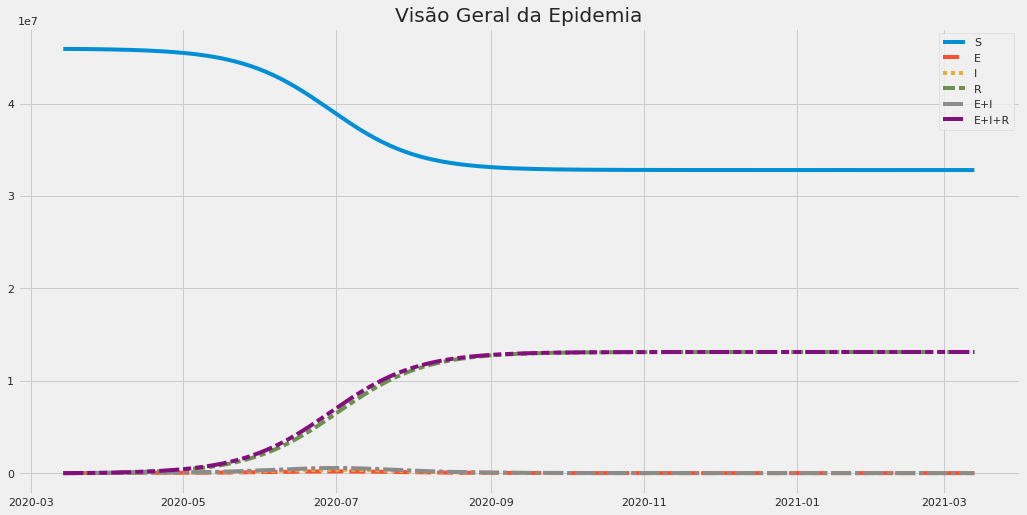

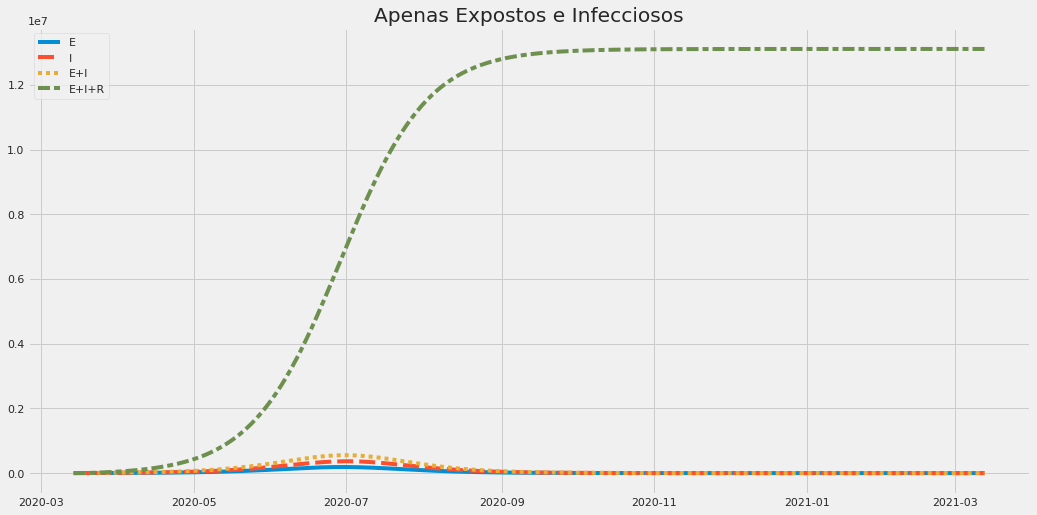

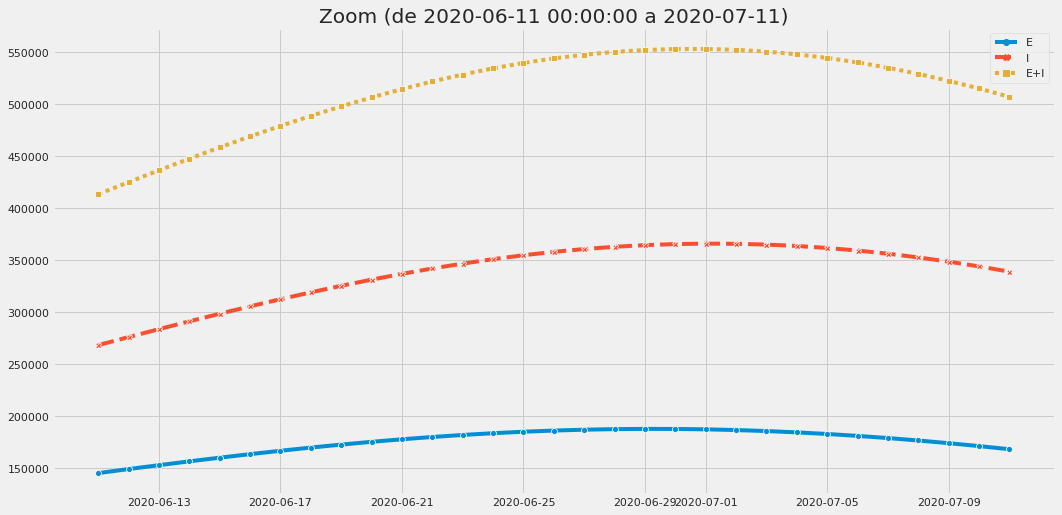

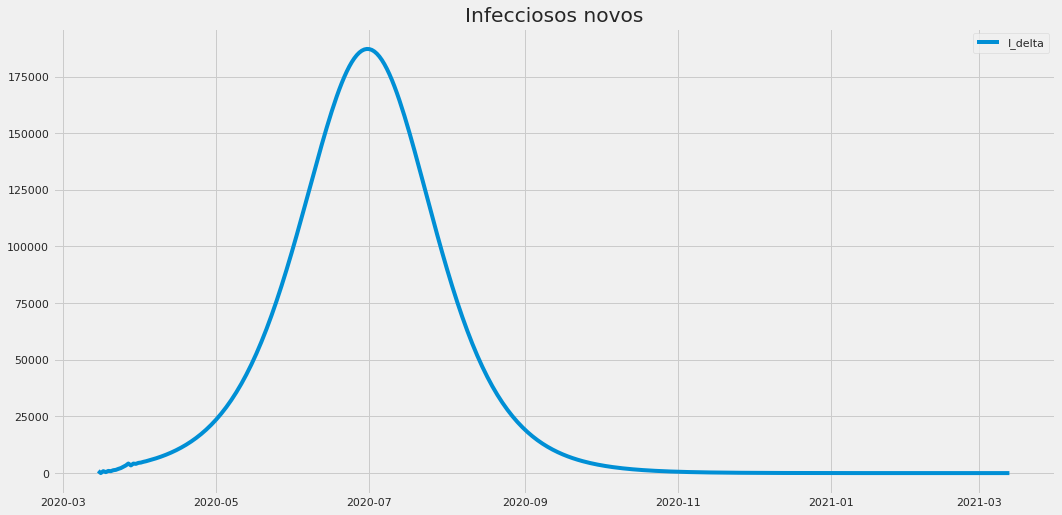

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

1.1750257705430989

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

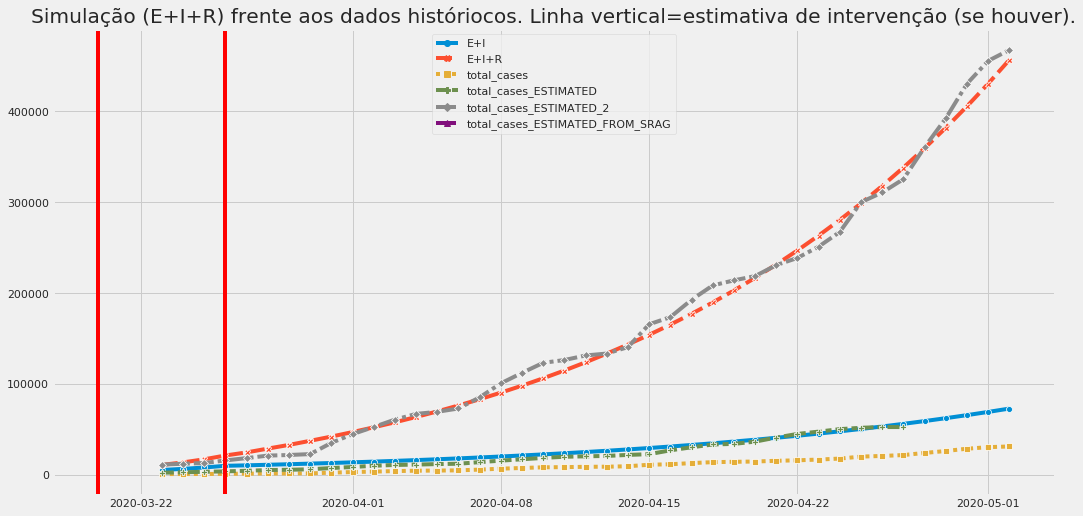

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

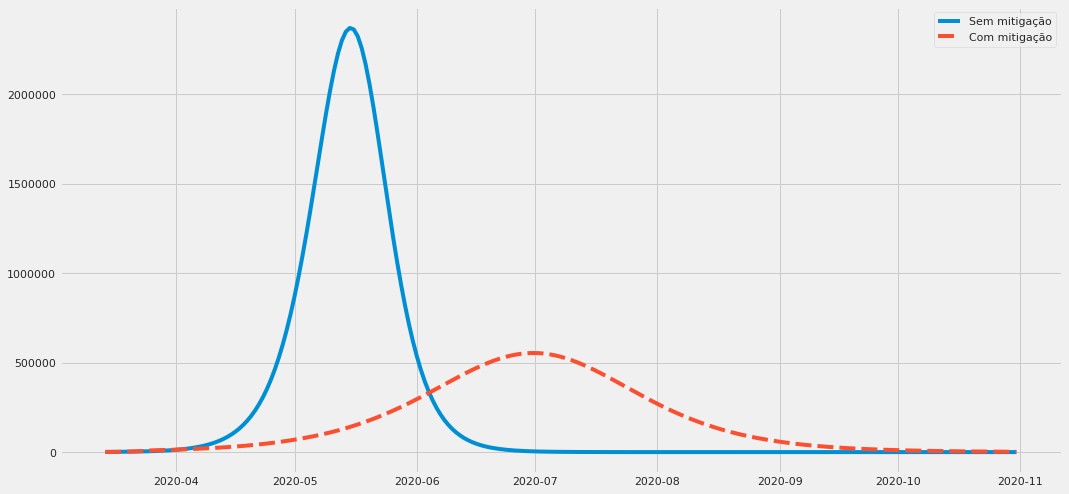

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

52

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.